# E-commerce Fraud Detection Analysis

## 1. Exploratory Data Analysis

### Read CSV and understand data format

In [1]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [158]:
# datafiles
glob.glob('./data/*')

['./data/test_transaction.csv',
 './data/train_identity.csv',
 './data/test_identity.csv',
 './data/sample_submission.csv',
 './data/train_transaction.csv']

In [159]:
df_id = pd.read_csv('./data/train_identity.csv')
df_transaction = pd.read_csv('./data/train_transaction.csv')

### Identity Table

There are 41 columns in this table, including different 
identity information such as network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. These data is collected by Vesta’s fraud protection system and digital security partners. Field names are masked for privacy reasons.

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [160]:
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [198]:
len(df_id.columns)

41

### Transaction Table

There are 394 columns in this table. The organization provided additinoal explanation regarding these variables.
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

In [162]:
df_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
len(df_transaction.columns)

394

### Data Exploration

In [164]:
df = df_id.join(df_transaction.set_index('TransactionID'), on='TransactionID')

Out of 590,540 data records, only ~3.5% are fraud transactions. It is very likely to encounter inbalanced classes in fraud detection problems. We will experiment with different ways to handle this, including various data sampling methods and using non-accuracy measures to evaluate model.

In [165]:
'Total number of Transactions', len(df_transaction.isFraud)

('Total number of Transactions', 590540)

('Ratio of fradulent transactions', 0.03499)

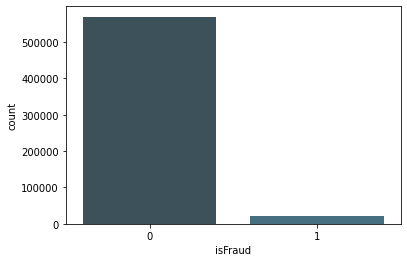

In [166]:
sns.set_palette('GnBu_d')
sns.countplot(x = 'isFraud', data = df_transaction)
'Ratio of fradulent transactions'\
, round(sum(df_transaction.isFraud)/ len(df_transaction.isFraud),5)

## 2. XGBoost model

###  Read cleaned data from pickle 

Preprocessing applied to all files:
- Features with > 90% data missing or > 90% data with the same value were dropped
- If possible, categorical variables with 100s of categories were mapped to coaser categoricals
- Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
	- https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
- Some "D" columns were normalized for time
- Aggregate features were added using "magic" technique
	- https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
- Dropped TransactionID and TransactionDT

In [2]:
import pickle

In [3]:
glob.glob('./data/clean_data/*')

['./data/clean_data/XGBoost_test_X_2.pkl',
 './data/clean_data/XGBoost_test_X_1.pkl',
 './data/clean_data/XGBoost_train_X_2.pkl',
 './data/clean_data/train_y.pkl',
 './data/clean_data/XGBoost_train_X_1.pkl',
 './data/clean_data/readmefirst.md']

In [4]:
'''X (version 1)
- Full 200 features
- Dummies created
'''
X_test_1 = pickle.load(open('./data/clean_data/XGBoost_test_X_1.pkl', 'rb'))
X_train_1 = pickle.load(open('./data/clean_data/XGBoost_train_X_1.pkl', 'rb'))

'''
X (version 2)
- Removed additional features
    - Highly correlated "C", "D" features
    - Removed features Chris (1st place winners) removed
    - Removed caterogical features withh 200+ categories even after 1)
- Dummies created
'''
X_test_2 = pickle.load(open('./data/clean_data/XGBoost_test_X_2.pkl', 'rb'))
X_train_2 = pickle.load(open('./data/clean_data/XGBoost_train_X_2.pkl', 'rb'))

y = pickle.load(open('./data/clean_data/train_y.pkl', 'rb'))

In [5]:
X_train_1.shape, X_train_2.shape, X_test_1.shape, X_test_2.shape, y.shape

((590540, 1323), (590540, 1303), (506691, 1573), (506691, 1553), (590540,))

### Base model

In [7]:
!pip install xgboost

     |████████████████████████████████| 821 kB 2.2 MB/s eta 0:00:01
  Created wheel for xgboost: filename=xgboost-1.0.2-cp37-cp37m-macosx_10_13_x86_64.whl size=3457469 sha256=68a5bff40bdd86cd729d3a0da042b353b4599e947eb17d5109bc932814550f41
  Stored in directory: /Users/kuly/Library/Caches/pip/wheels/c9/1c/c9/db0188e82127a4f3c66d031147312a03e8a0676d907ecd7fbb
Successfully built xgboost


['Booster',
 'DMatrix',
 'RabitTracker',
 'VERSION_FILE',
 'XGBClassifier',
 'XGBModel',
 'XGBRFClassifier',
 'XGBRFRegressor',
 'XGBRanker',
 'XGBRegressor',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'callback',
 'compat',
 'core',
 'cv',
 'dask',
 'f',
 'libpath',
 'os',
 'plot_importance',
 'plot_tree',
 'plotting',
 'rabit',
 'sklearn',
 'sys',
 'to_graphviz',
 'tracker',
 'train',
 'training',
 'warnings']

In [9]:
from sklearn.model_selection import train_test_split, cross_validate,\
KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.metrics import make_scorer
import hyperopt as hp

#### Since xgboost takes a considerable amount of time to run on non-GPU device, the following is a train-test split setup to assist with early stage coding/ debugging.

In [10]:
%%time
seed = 123
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y, test_size = test_size, random_state = seed)

In [11]:
%%time
model = xgb.XGBClassifier(eval_metric='auc')
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [12]:
%%time
y_pred = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
m1_frp, m1_tpr, _ = roc_curve(y_val, y_pred)

ROC_AUC score: 95.00%


In [15]:
%%time
model2 = XGBClassifier(n_estimators=2000,
max_depth=12, 
learning_rate=0.02, 
subsample=0.8,
colsample_bytree=0.4, 
missing=-1, 
eval_metric='auc',
tree_method='hist')

In [16]:
%%time
model2.fit(X_train, y_train)
y_pred = model2.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
m2_frp, m2_tpr, _ = roc_curve(y_val, y_pred)

ROC_AUC score: 97.83%


In [ ]:
# USE CPU
#nthread=4,
#tree_method='hist' 
# USE GPU
#tree_method='gpu_hist' 

In [17]:
%%time
no_skill_pred = [0 for _ in range(len(y_val))]
ns_frp, ns_tpr, _ = roc_curve(y_val, no_skill_pred)

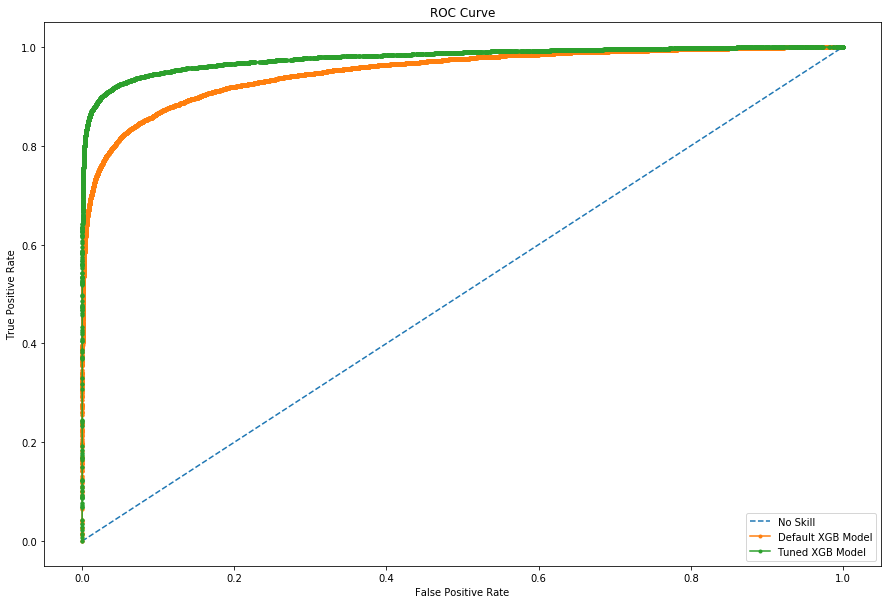

In [29]:
# plot ROC curve across models
plt.figure(figsize=(15, 10))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(m1_frp, m1_tpr, marker = '.', label='Default XGB Model')
plt.plot(m2_frp, m2_tpr, marker = '.', label='Tuned XGB Model')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

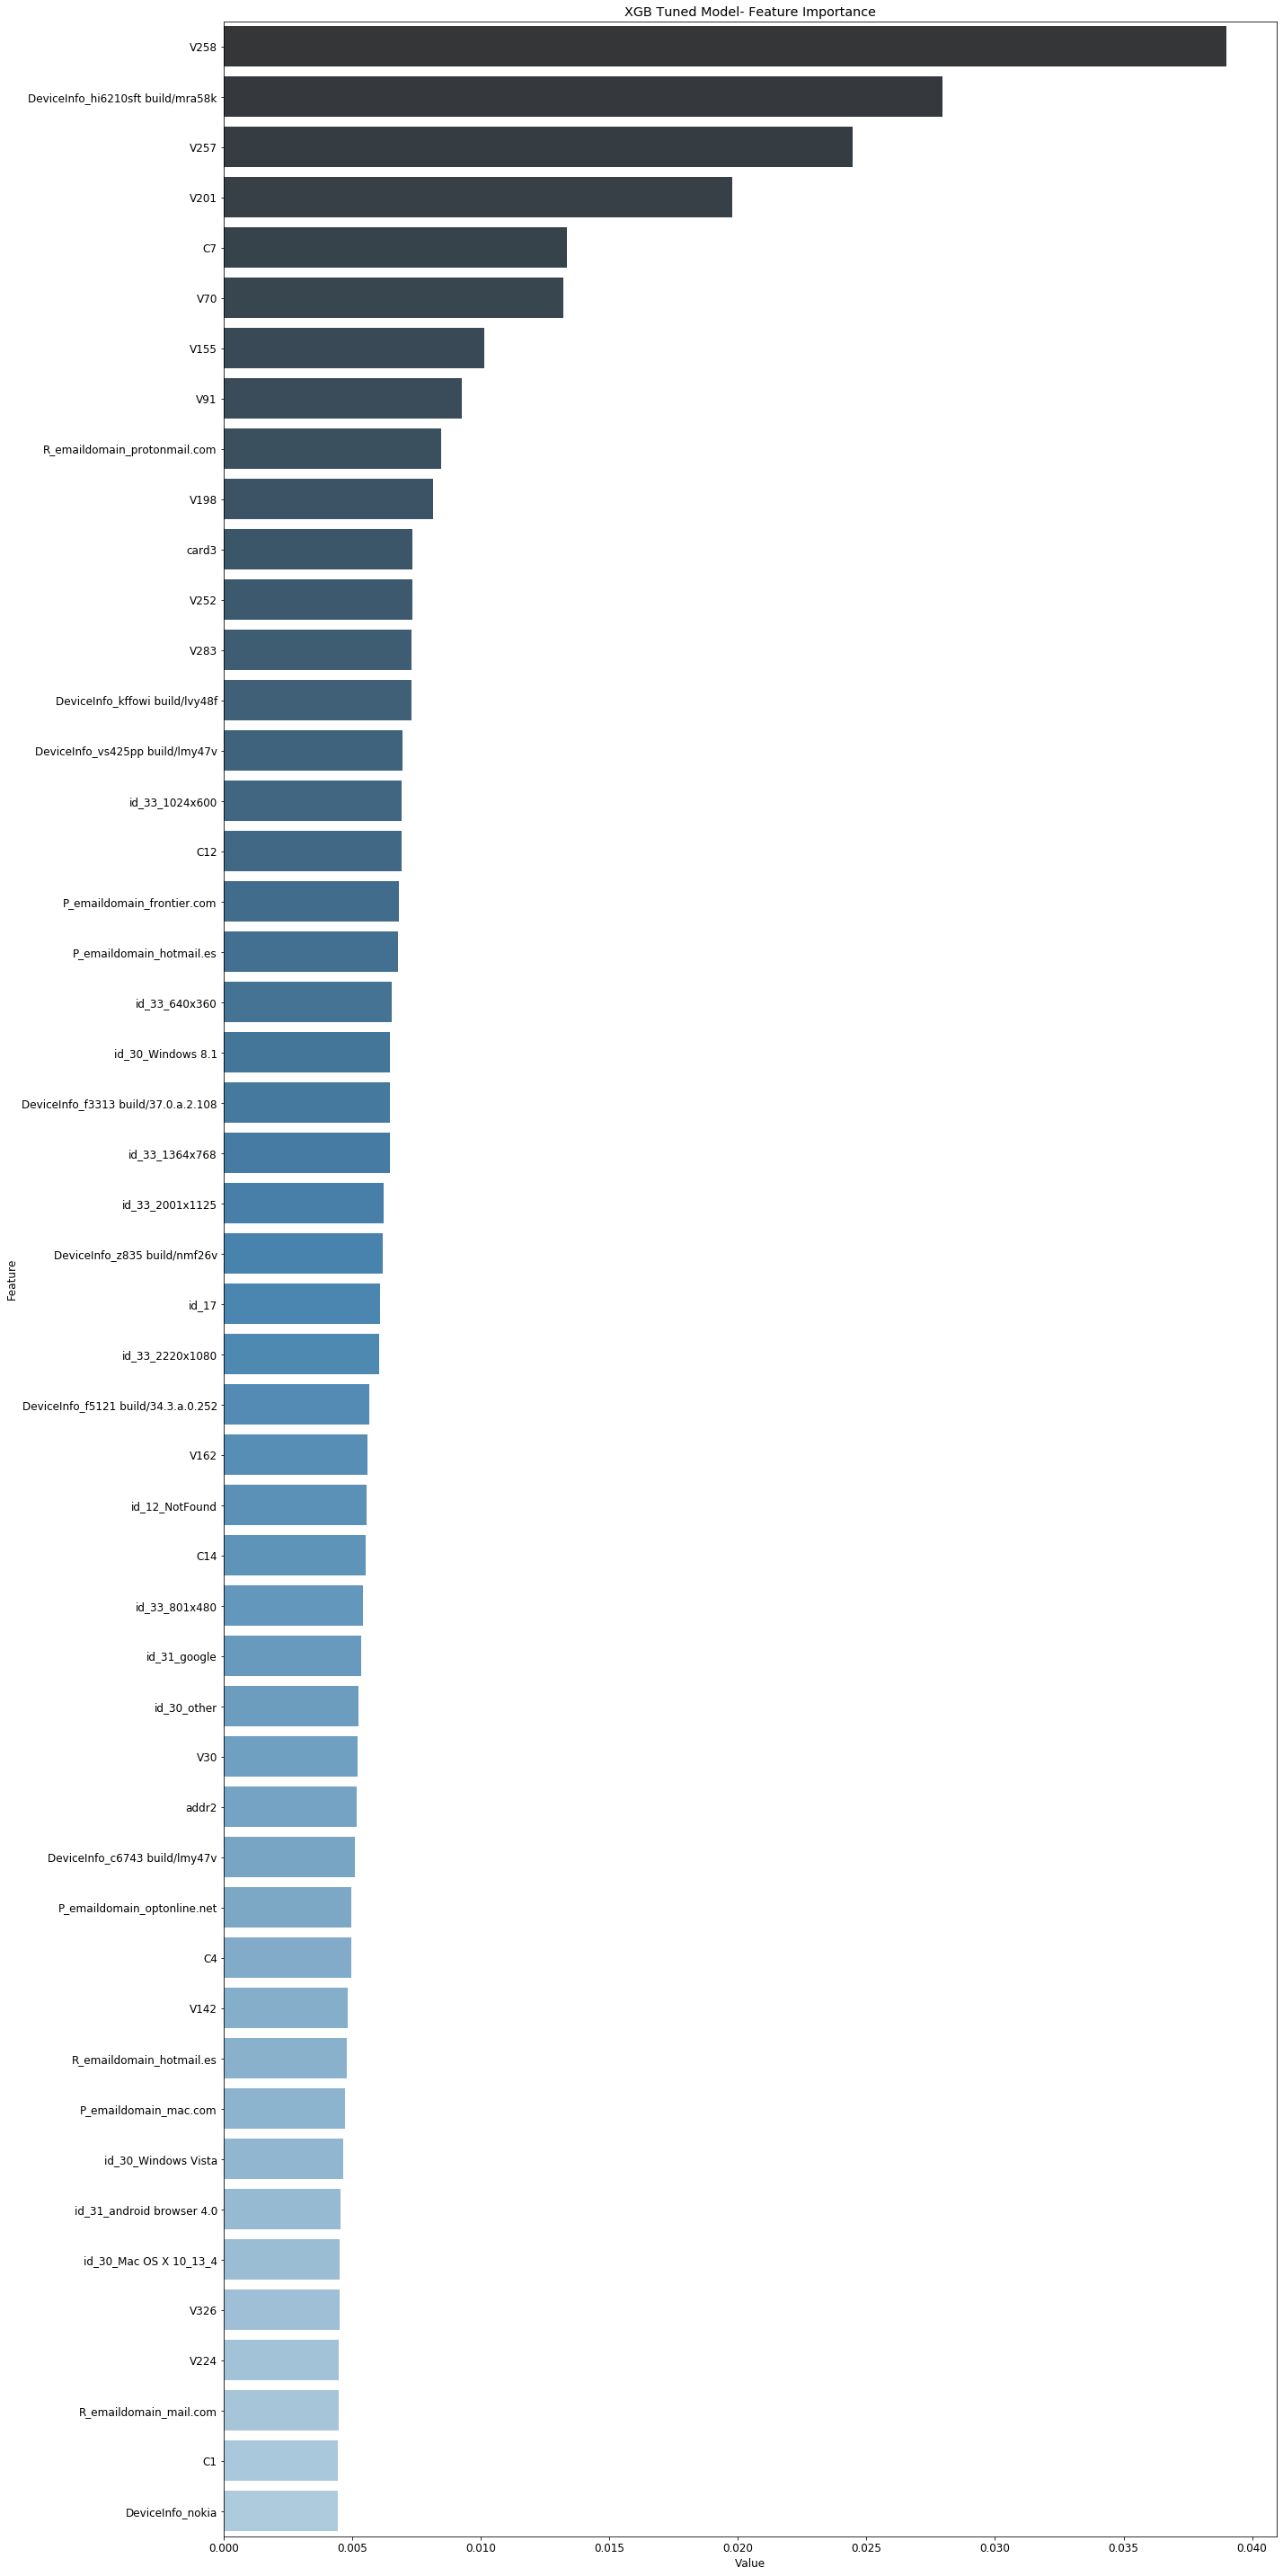

CPU times: user 8.95 s, sys: 93.4 ms, total: 9.04 s
Wall time: 9.07 s


In [40]:
%%time
# Understand feature importance in the model
feature_imp = pd.DataFrame(sorted(zip(model2.feature_importances_,X_train_1.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50],\
            palette = "Blues_d")
plt.title('XGB Tuned Model- Feature Importance')
plt.tight_layout()
plt.show()

In [41]:
# What is our best model predicting?
# With a threshold of 0.5, how many fraud transactions are we flagging?
predictions = model2.predict(X_val)
sum(predictions)/len(predictions)

ValueError: feature_names mismatch: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_32', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V17', 'V20', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V70', 'V76', 'V78', 'V80', 'V82', 'V87', 'V91', 'V99', 'V127', 'V130', 'V138', 'V139', 'V142', 'V147', 'V155', 'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V174', 'V175', 'V180', 'V185', 'V198', 'V201', 'V203', 'V205', 'V206', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258', 'V260', 'V261', 'V264', 'V266', 'V267', 'V271', 'V274', 'V277', 'V283', 'V285', 'V289', 'V291', 'V303', 'V307', 'V310', 'V314', 'V325', 'V326', 'V332', 'V335', 'V338', 'cents', 'addr1_FE', 'card1_FE', 'card2_FE', 'card3_FE', 'P_emaildomain_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'card1_addr1_FE', 'card1_addr1_P_emaildomain_FE', 'TransactionAmt_card1_mean', 'TransactionAmt_card1_std', 'TransactionAmt_card1_addr1_mean', 'TransactionAmt_card1_addr1_std', 'TransactionAmt_card1_addr1_P_emaildomain_mean', 'TransactionAmt_card1_addr1_P_emaildomain_std', 'D9_card1_mean', 'D9_card1_std', 'D9_card1_addr1_mean', 'D9_card1_addr1_std', 'D9_card1_addr1_P_emaildomain_mean', 'D9_card1_addr1_P_emaildomain_std', 'D11_card1_mean', 'D11_card1_std', 'D11_card1_addr1_mean', 'D11_card1_addr1_std', 'D11_card1_addr1_P_emaildomain_mean', 'D11_card1_addr1_P_emaildomain_std', 'id_12_NotFound', 'id_15_New', 'id_15_Unknown', 'id_16_NotFound', 'id_28_New', 'id_29_NotFound', 'id_30_Android 4.4.2', 'id_30_Android 5.0', 'id_30_Android 5.0.2', 'id_30_Android 5.1.1', 'id_30_Android 6.0', 'id_30_Android 6.0.1', 'id_30_Android 7.0', 'id_30_Android 7.1.1', 'id_30_Android 7.1.2', 'id_30_Android 8.0.0', 'id_30_Android 8.1.0', 'id_30_Linux', 'id_30_Mac', 'id_30_Mac OS X 10.10', 'id_30_Mac OS X 10.11', 'id_30_Mac OS X 10.12', 'id_30_Mac OS X 10.13', 'id_30_Mac OS X 10.6', 'id_30_Mac OS X 10.9', 'id_30_Mac OS X 10_10_5', 'id_30_Mac OS X 10_11_3', 'id_30_Mac OS X 10_11_4', 'id_30_Mac OS X 10_11_5', 'id_30_Mac OS X 10_11_6', 'id_30_Mac OS X 10_12', 'id_30_Mac OS X 10_12_1', 'id_30_Mac OS X 10_12_2', 'id_30_Mac OS X 10_12_3', 'id_30_Mac OS X 10_12_4', 'id_30_Mac OS X 10_12_5', 'id_30_Mac OS X 10_12_6', 'id_30_Mac OS X 10_13_1', 'id_30_Mac OS X 10_13_2', 'id_30_Mac OS X 10_13_3', 'id_30_Mac OS X 10_13_4', 'id_30_Mac OS X 10_13_5', 'id_30_Mac OS X 10_6_8', 'id_30_Mac OS X 10_7_5', 'id_30_Mac OS X 10_8_5', 'id_30_Mac OS X 10_9_5', 'id_30_Windows', 'id_30_Windows 10', 'id_30_Windows 7', 'id_30_Windows 8', 'id_30_Windows 8.1', 'id_30_Windows Vista', 'id_30_Windows XP', 'id_30_func', 'id_30_iOS', 'id_30_iOS 10.0.2', 'id_30_iOS 10.1.1', 'id_30_iOS 10.2.0', 'id_30_iOS 10.2.1', 'id_30_iOS 10.3.1', 'id_30_iOS 10.3.2', 'id_30_iOS 10.3.3', 'id_30_iOS 11.0.0', 'id_30_iOS 11.0.1', 'id_30_iOS 11.0.2', 'id_30_iOS 11.0.3', 'id_30_iOS 11.1.0', 'id_30_iOS 11.1.1', 'id_30_iOS 11.1.2', 'id_30_iOS 11.2.0', 'id_30_iOS 11.2.1', 'id_30_iOS 11.2.2', 'id_30_iOS 11.2.5', 'id_30_iOS 11.2.6', 'id_30_iOS 11.3.0', 'id_30_iOS 11.3.1', 'id_30_iOS 11.4.0', 'id_30_iOS 11.4.1', 'id_30_iOS 9.3.5', 'id_30_other', 'id_31_android browser 4.0', 'id_31_aol', 'id_31_blu/dash', 'id_31_cherry', 'id_31_chrome', 'id_31_chromium', 'id_31_comodo', 'id_31_cyberfox', 'id_31_edge', 'id_31_facebook', 'id_31_firefox', 'id_31_generic/android', 'id_31_generic/android 7.0', 'id_31_google', 'id_31_icedragon', 'id_31_ie', 'id_31_inco/minion', 'id_31_iron', 'id_31_lanix/ilium', 'id_31_lg/k-200', 'id_31_line', 'id_31_m4tel/m4', 'id_31_maxthon', 'id_31_microsoft/windows', 'id_31_mobile', 'id_31_nokia/lumia', 'id_31_opera', 'id_31_other', 'id_31_palemoon', 'id_31_puffin', 'id_31_safari', 'id_31_samsung', 'id_31_seamonkey', 'id_31_silk', 'id_31_waterfox', 'id_31_zte/blade', 'id_34_match_status:0', 'id_34_match_status:1', 'id_34_match_status:2', 'id_35_T', 'id_36_T', 'id_37_T', 'id_38_T', 'DeviceType_mobile', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit', 'card6_debit', 'card6_debit or credit', 'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com', 'P_emaildomain_att.net', 'P_emaildomain_bellsouth.net', 'P_emaildomain_cableone.net', 'P_emaildomain_centurylink.net', 'P_emaildomain_cfl.rr.com', 'P_emaildomain_charter.net', 'P_emaildomain_comcast.net', 'P_emaildomain_cox.net', 'P_emaildomain_earthlink.net', 'P_emaildomain_embarqmail.com', 'P_emaildomain_frontier.com', 'P_emaildomain_frontiernet.net', 'P_emaildomain_gmail', 'P_emaildomain_gmail.com', 'P_emaildomain_gmx.de', 'P_emaildomain_hotmail.co.uk', 'P_emaildomain_hotmail.com', 'P_emaildomain_hotmail.de', 'P_emaildomain_hotmail.es', 'P_emaildomain_hotmail.fr', 'P_emaildomain_icloud.com', 'P_emaildomain_juno.com', 'P_emaildomain_live.com', 'P_emaildomain_live.com.mx', 'P_emaildomain_live.fr', 'P_emaildomain_mac.com', 'P_emaildomain_mail.com', 'P_emaildomain_me.com', 'P_emaildomain_msn.com', 'P_emaildomain_netzero.com', 'P_emaildomain_netzero.net', 'P_emaildomain_optonline.net', 'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es', 'P_emaildomain_prodigy.net.mx', 'P_emaildomain_protonmail.com', 'P_emaildomain_ptd.net', 'P_emaildomain_q.com', 'P_emaildomain_roadrunner.com', 'P_emaildomain_rocketmail.com', 'P_emaildomain_sbcglobal.net', 'P_emaildomain_sc.rr.com', 'P_emaildomain_servicios-ta.com', 'P_emaildomain_suddenlink.net', 'P_emaildomain_twc.com', 'P_emaildomain_verizon.net', 'P_emaildomain_web.de', 'P_emaildomain_windstream.net', 'P_emaildomain_yahoo.co.jp', 'P_emaildomain_yahoo.co.uk', 'P_emaildomain_yahoo.com', 'P_emaildomain_yahoo.com.mx', 'P_emaildomain_yahoo.de', 'P_emaildomain_yahoo.es', 'P_emaildomain_yahoo.fr', 'P_emaildomain_ymail.com', 'R_emaildomain_anonymous.com', 'R_emaildomain_aol.com', 'R_emaildomain_att.net', 'R_emaildomain_bellsouth.net', 'R_emaildomain_cableone.net', 'R_emaildomain_centurylink.net', 'R_emaildomain_cfl.rr.com', 'R_emaildomain_charter.net', 'R_emaildomain_comcast.net', 'R_emaildomain_cox.net', 'R_emaildomain_earthlink.net', 'R_emaildomain_embarqmail.com', 'R_emaildomain_frontier.com', 'R_emaildomain_frontiernet.net', 'R_emaildomain_gmail', 'R_emaildomain_gmail.com', 'R_emaildomain_gmx.de', 'R_emaildomain_hotmail.co.uk', 'R_emaildomain_hotmail.com', 'R_emaildomain_hotmail.de', 'R_emaildomain_hotmail.es', 'R_emaildomain_hotmail.fr', 'R_emaildomain_icloud.com', 'R_emaildomain_juno.com', 'R_emaildomain_live.com', 'R_emaildomain_live.com.mx', 'R_emaildomain_live.fr', 'R_emaildomain_mac.com', 'R_emaildomain_mail.com', 'R_emaildomain_me.com', 'R_emaildomain_msn.com', 'R_emaildomain_netzero.com', 'R_emaildomain_netzero.net', 'R_emaildomain_optonline.net', 'R_emaildomain_outlook.com', 'R_emaildomain_outlook.es', 'R_emaildomain_prodigy.net.mx', 'R_emaildomain_protonmail.com', 'R_emaildomain_ptd.net', 'R_emaildomain_q.com', 'R_emaildomain_roadrunner.com', 'R_emaildomain_rocketmail.com', 'R_emaildomain_sbcglobal.net', 'R_emaildomain_sc.rr.com', 'R_emaildomain_scranton.edu', 'R_emaildomain_servicios-ta.com', 'R_emaildomain_suddenlink.net', 'R_emaildomain_twc.com', 'R_emaildomain_verizon.net', 'R_emaildomain_web.de', 'R_emaildomain_windstream.net', 'R_emaildomain_yahoo.co.jp', 'R_emaildomain_yahoo.co.uk', 'R_emaildomain_yahoo.com', 'R_emaildomain_yahoo.com.mx', 'R_emaildomain_yahoo.de', 'R_emaildomain_yahoo.es', 'R_emaildomain_yahoo.fr', 'R_emaildomain_ymail.com', 'M1_T', 'M2_T', 'M3_T', 'M4_M1', 'M4_M2', 'M5_T', 'M6_T', 'M7_T', 'M8_T', 'M9_T', 'id_33_1023x767', 'id_33_1023x768', 'id_33_1024x552', 'id_33_1024x600', 'id_33_1024x640', 'id_33_1024x767', 'id_33_1024x768', 'id_33_1024x819', 'id_33_1025x768', 'id_33_1062x630', 'id_33_1092x614', 'id_33_1093x615', 'id_33_1120x700', 'id_33_1136x640', 'id_33_1138x640', 'id_33_1152x648', 'id_33_1152x720', 'id_33_1152x864', 'id_33_1184x720', 'id_33_1188x720', 'id_33_1200x675', 'id_33_1200x720', 'id_33_1229x691', 'id_33_1232x800', 'id_33_1239x697', 'id_33_1264x924', 'id_33_1272x960', 'id_33_1279x1023', 'id_33_1279x1024', 'id_33_1280x1023', 'id_33_1280x1024', 'id_33_1280x1025', 'id_33_1280x600', 'id_33_1280x620', 'id_33_1280x712', 'id_33_1280x720', 'id_33_1280x732', 'id_33_1280x740', 'id_33_1280x768', 'id_33_1280x800', 'id_33_1280x900', 'id_33_1280x960', 'id_33_1281x720', 'id_33_1281x721', 'id_33_1281x800', 'id_33_1281x801', 'id_33_1296x774', 'id_33_1334x750', 'id_33_1344x756', 'id_33_1344x840', 'id_33_1356x900', 'id_33_1359x768', 'id_33_1360x767', 'id_33_1360x768', 'id_33_1364x768', 'id_33_1365x767', 'id_33_1365x768', 'id_33_1366x1024', 'id_33_1366x767', 'id_33_1366x768', 'id_33_1368x768', 'id_33_1371x857', 'id_33_1400x1050', 'id_33_1400x900', 'id_33_1408x792', 'id_33_1408x880', 'id_33_1422x889', 'id_33_1439x809', 'id_33_1439x899', 'id_33_1439x900', 'id_33_1440x720', 'id_33_1440x759', 'id_33_1440x800', 'id_33_1440x803', 'id_33_1440x810', 'id_33_1440x899', 'id_33_1440x900', 'id_33_1440x960', 'id_33_1441x901', 'id_33_1480x720', 'id_33_1496x844', 'id_33_1502x844', 'id_33_1502x845', 'id_33_1511x944', 'id_33_1512x945', 'id_33_1536x1152', 'id_33_1536x864', 'id_33_1536x960', 'id_33_1584x990', 'id_33_1596x710', 'id_33_1599x899', 'id_33_1599x900', 'id_33_1600x1000', 'id_33_1600x1024', 'id_33_1600x1200', 'id_33_1600x837', 'id_33_1600x899', 'id_33_1600x900', 'id_33_1624x1080', 'id_33_1638x922', 'id_33_1658x946', 'id_33_1679x1049', 'id_33_1680x1049', 'id_33_1680x1050', 'id_33_1680x1051', 'id_33_1680x945', 'id_33_1684x947', 'id_33_1700x960', 'id_33_1707x960', 'id_33_1720x1440', 'id_33_1727x971', 'id_33_1728x972', 'id_33_1729x973', 'id_33_1760x990', 'id_33_1768x992', 'id_33_1776x1000', 'id_33_1776x1080', 'id_33_1800x1125', 'id_33_1805x1015', 'id_33_1824x1026', 'id_33_1848x1155', 'id_33_1888x941', 'id_33_1912x1025', 'id_33_1916x901', 'id_33_1918x1080', 'id_33_1919x1079', 'id_33_1919x1080', 'id_33_1919x1199', 'id_33_1919x1200', 'id_33_1920x1018', 'id_33_1920x1079', 'id_33_1920x1080', 'id_33_1920x1081', 'id_33_1920x1200', 'id_33_1920x1201', 'id_33_1920x1279', 'id_33_1920x1280', 'id_33_1920x1281', 'id_33_1920x975', 'id_33_1921x1080', 'id_33_1921x1081', 'id_33_2000x1125', 'id_33_2001x1125', 'id_33_2010x1080', 'id_33_2048x1080', 'id_33_2048x1152', 'id_33_2048x1278', 'id_33_2048x1280', 'id_33_2048x1536', 'id_33_2049x1152', 'id_33_2049x1536', 'id_33_2076x1080', 'id_33_2100x1312', 'id_33_2112x1188', 'id_33_2159x1439', 'id_33_2159x1440', 'id_33_2160x1080', 'id_33_2160x1081', 'id_33_2160x1215', 'id_33_2160x1350', 'id_33_2160x1439', 'id_33_2160x1440', 'id_33_2208x1242', 'id_33_2220x1080', 'id_33_2220x1081', 'id_33_2224x1668', 'id_33_2255x1503', 'id_33_2256x1504', 'id_33_2304x1296', 'id_33_2304x1440', 'id_33_2368x1440', 'id_33_2392x1440', 'id_33_2400x1350', 'id_33_2400x1500', 'id_33_2400x1600', 'id_33_2436x1125', 'id_33_2520x1575', 'id_33_2552x1337', 'id_33_2559x1439', 'id_33_2559x1440', 'id_33_2560x1080', 'id_33_2560x1440', 'id_33_2560x1600', 'id_33_2560x1700', 'id_33_2560x1800', 'id_33_2561x1442', 'id_33_2562x1442', 'id_33_2591x1619', 'id_33_2672x1440', 'id_33_2700x1800', 'id_33_2710x1440', 'id_33_2732x2048', 'id_33_2735x1823', 'id_33_2735x1825', 'id_33_2736x1823', 'id_33_2736x1824', 'id_33_2737x1825', 'id_33_2800x1575', 'id_33_2816x1584', 'id_33_2816x1760', 'id_33_2880x1440', 'id_33_2880x1442', 'id_33_2880x1620', 'id_33_2880x1800', 'id_33_2882x1442', 'id_33_2960x1440', 'id_33_2961x1440', 'id_33_2961x1442', 'id_33_2999x2000', 'id_33_3000x2000', 'id_33_3001x2000', 'id_33_3072x1728', 'id_33_3199x1800', 'id_33_3200x1800', 'id_33_3200x2000', 'id_33_3201x1800', 'id_33_3240x2160', 'id_33_3360x1050', 'id_33_3360x1890', 'id_33_3360x2100', 'id_33_3440x1440', 'id_33_3441x1440', 'id_33_3520x1980', 'id_33_3600x2250', 'id_33_3696x2310', 'id_33_3838x2158', 'id_33_3838x2160', 'id_33_3839x2159', 'id_33_3839x2160', 'id_33_3840x1080', 'id_33_3840x1600', 'id_33_3840x2160', 'id_33_3840x2162', 'id_33_3840x2400', 'id_33_3841x2161', 'id_33_3843x2163', 'id_33_4096x2304', 'id_33_4200x2625', 'id_33_4499x2999', 'id_33_4500x3000', 'id_33_480x320', 'id_33_5040x3150', 'id_33_5120x2880', 'id_33_5760x1080', 'id_33_5760x3240', 'id_33_600x450', 'id_33_6016x3384', 'id_33_6400x3600', 'id_33_640x360', 'id_33_6720x3780', 'id_33_7500x5000', 'id_33_768x576', 'id_33_800x600', 'id_33_801x480', 'id_33_855x480', 'id_33_921x691', 'id_33_960x540', 'id_33_960x640', 'id_33_976x600', 'DeviceInfo_0pja2', 'DeviceInfo_0pm92', 'DeviceInfo_1016s', 'DeviceInfo_2pq93', 'DeviceInfo_2ps64 build/nrd90m', 'DeviceInfo_2pyb2', 'DeviceInfo_2pzc5', 'DeviceInfo_4003a', 'DeviceInfo_4009f', 'DeviceInfo_4013m build/kot49h', 'DeviceInfo_4027a build/kot49h', 'DeviceInfo_4034e', 'DeviceInfo_4034g', 'DeviceInfo_4047a build/nrd90m', 'DeviceInfo_4047g build/nrd90m', 'DeviceInfo_47418', 'DeviceInfo_5010g build/mra58k', 'DeviceInfo_5010s build/mra58k', 'DeviceInfo_5011a build/nrd90m', 'DeviceInfo_5012g build/mra58k', 'DeviceInfo_5015a build/lmy47i', 'DeviceInfo_5017a', 'DeviceInfo_5025g build/lmy47i', 'DeviceInfo_5042a', 'DeviceInfo_5044a', 'DeviceInfo_5045i', 'DeviceInfo_5049w build/nrd90m', 'DeviceInfo_5051a build/mmb29m', 'DeviceInfo_5054n', 'DeviceInfo_5054s build/lmy47v', 'DeviceInfo_5056a build/mmb29m', 'DeviceInfo_5056n', 'DeviceInfo_5057m', 'DeviceInfo_5080a build/mra58k', 'DeviceInfo_5085b build/mra58k', 'DeviceInfo_5095i build/mra58k', 'DeviceInfo_6037b', 'DeviceInfo_6039a build/lrx22g', 'DeviceInfo_6045i build/lrx22g', 'DeviceInfo_6055b', 'DeviceInfo_7048a build/lrx22g', 'DeviceInfo_7055a build/kvt49l', 'DeviceInfo_7_plus', 'DeviceInfo_8050g build/lmy47i', 'DeviceInfo_8062 build/mra58k', 'DeviceInfo_8080 build/lrx21m', 'DeviceInfo_831c', 'DeviceInfo_9002a', 'DeviceInfo_9003a build/mra58k', 'DeviceInfo_9008a build/nrd90m', 'DeviceInfo_9022x', 'DeviceInfo_916', 'DeviceInfo_9203a build/mra58k', 'DeviceInfo_a0001', 'DeviceInfo_a0001 build/mhc19q', 'DeviceInfo_a1-850', 'DeviceInfo_a1601 build/lmy47i', 'DeviceInfo_a3-a20', 'DeviceInfo_a37f', 'DeviceInfo_a3_mini', 'DeviceInfo_a463bg', 'DeviceInfo_a466bg', 'DeviceInfo_a5002', 'DeviceInfo_a50c+', 'DeviceInfo_a574bl build/nmf26f', 'DeviceInfo_a577vl', 'DeviceInfo_a621r', 'DeviceInfo_a9', 'DeviceInfo_a952', 'DeviceInfo_a96 build/lmy47i', 'DeviceInfo_a97', 'DeviceInfo_advance', 'DeviceInfo_aerial', 'DeviceInfo_aerial build/nrd90m', 'DeviceInfo_akus', 'DeviceInfo_alcatel', 'DeviceInfo_ale-', 'DeviceInfo_alter', 'DeviceInfo_alumini', 'DeviceInfo_am508', 'DeviceInfo_android', 'DeviceInfo_aoc_u706g', 'DeviceInfo_aquaris', 'DeviceInfo_archos', 'DeviceInfo_astro', 'DeviceInfo_asus', 'DeviceInfo_att', 'DeviceInfo_att-ie11', 'DeviceInfo_ax1060', 'DeviceInfo_ax1070', 'DeviceInfo_ax705', 'DeviceInfo_ax820 build/mra58k', 'DeviceInfo_ax821 build/mra58k', 'DeviceInfo_ax920', 'DeviceInfo_ax921 build/mra58k', 'DeviceInfo_azumi', 'DeviceInfo_b1-750', 'DeviceInfo_b1-790', 'DeviceInfo_b1-810', 'DeviceInfo_b3-a20', 'DeviceInfo_b3-a40', 'DeviceInfo_bba100-1', 'DeviceInfo_bba100-2', 'DeviceInfo_bbb100-1', 'DeviceInfo_bbb100-2', 'DeviceInfo_bbb100-3', 'DeviceInfo_beat', 'DeviceInfo_bg2-w09', 'DeviceInfo_blade', 'DeviceInfo_bln-l21 build/honorbln-l21', 'DeviceInfo_bln-l24 build/honorbln-l24', 'DeviceInfo_blu', 'DeviceInfo_blu energy x plus build/lrx21m', 'DeviceInfo_blu life xl build/l050u', 'DeviceInfo_blu studio c 5+5 build/lrx21m', 'DeviceInfo_bnd-l21 build/honorbnd-l21', 'DeviceInfo_bnd-l34', 'DeviceInfo_bntv400', 'DeviceInfo_boie9', 'DeviceInfo_bolt', 'DeviceInfo_build/kot49h', 'DeviceInfo_build/opm1.171019.011', 'DeviceInfo_build/opr1.170623.032', 'DeviceInfo_build/opr6.170623.013', 'DeviceInfo_bv6000', 'DeviceInfo_bv7000', 'DeviceInfo_bv8000pro', 'DeviceInfo_c1904', 'DeviceInfo_c2104', 'DeviceInfo_c6603', 'DeviceInfo_c6743 build/lmy47v', 'DeviceInfo_c6903', 'DeviceInfo_c6906', 'DeviceInfo_c6906 build/14.6.a.1.236', 'DeviceInfo_cam-l23', 'DeviceInfo_clt-l09', 'DeviceInfo_coolpad', 'DeviceInfo_covet build/nrd90m', 'DeviceInfo_cph1607', 'DeviceInfo_cph1701', 'DeviceInfo_cph1723', 'DeviceInfo_cro', 'DeviceInfo_d2306', 'DeviceInfo_d2306 build/18.6.a.0.182', 'DeviceInfo_d2406', 'DeviceInfo_d5106', 'DeviceInfo_d5306', 'DeviceInfo_d5306 build/19.4.a.0.182', 'DeviceInfo_d5316', 'DeviceInfo_d5316 build/19.4.a.0.182', 'DeviceInfo_d5503', 'DeviceInfo_d5803 build/23.5.a.1.291', 'DeviceInfo_d6503', 'DeviceInfo_d6603', 'DeviceInfo_d6603 build/23.5.a.1.291', 'DeviceInfo_d6708', 'DeviceInfo_dash', 'DeviceInfo_dli-l22 build/honordli-l22', 'DeviceInfo_domos', 'DeviceInfo_dream', 'DeviceInfo_dt0704k08', 'DeviceInfo_duk-al20', 'DeviceInfo_e2006', 'DeviceInfo_e2104', 'DeviceInfo_e2104 build/24.0.a.5.14', 'DeviceInfo_e2303', 'DeviceInfo_e2306 build/26.1.a.3.111', 'DeviceInfo_e2306 build/26.3.a.1.33', 'DeviceInfo_e501', 'DeviceInfo_e5306', 'DeviceInfo_e5306 build/27.3.a.0.129', 'DeviceInfo_e5306 build/27.3.a.0.165', 'DeviceInfo_e5506', 'DeviceInfo_e5506 build/29.1.a.0.101', 'DeviceInfo_e5506 build/29.2.a.0.166', 'DeviceInfo_e5606', 'DeviceInfo_e5606 build/30.2.a.1.21', 'DeviceInfo_e5803', 'DeviceInfo_e5803 build/32.4.a.1.54', 'DeviceInfo_e5823', 'DeviceInfo_e5823 build/32.4.a.1.54', 'DeviceInfo_e6553', 'DeviceInfo_e6603', 'DeviceInfo_e6603 build/32.4.a.1.54', 'DeviceInfo_e6633', 'DeviceInfo_e6653 build/32.4.a.1.54', 'DeviceInfo_e6683', 'DeviceInfo_e6790tm', 'DeviceInfo_e6810', 'DeviceInfo_e6810 build/5.320vz.03.r', 'DeviceInfo_e6833', 'DeviceInfo_e6853', 'DeviceInfo_e6853 build/32.4.a.1.54', 'DeviceInfo_e8qp', 'DeviceInfo_edison', 'DeviceInfo_ego', 'DeviceInfo_en-gb', 'DeviceInfo_en-us', 'DeviceInfo_energy x 2 build/e050l', 'DeviceInfo_es-mx', 'DeviceInfo_es-us', 'DeviceInfo_f1f build/lmy47v', 'DeviceInfo_f3111 build/33.3.a.1.115', 'DeviceInfo_f3111 build/33.3.a.1.97', 'DeviceInfo_f3113', 'DeviceInfo_f3113 build/33.2.a.3.81', 'DeviceInfo_f3113 build/33.2.a.4.70', 'DeviceInfo_f3113 build/33.3.a.1.97', 'DeviceInfo_f3213', 'DeviceInfo_f3213 build/36.0.a.2.146', 'DeviceInfo_f3213 build/36.1.a.1.86', 'DeviceInfo_f3311', 'DeviceInfo_f3313', 'DeviceInfo_f3313 build/37.0.a.2.108', 'DeviceInfo_f3313 build/37.0.a.2.248', 'DeviceInfo_f5121', 'DeviceInfo_f5121 build/34.3.a.0.228', 'DeviceInfo_f5121 build/34.3.a.0.238', 'DeviceInfo_f5121 build/34.3.a.0.252', 'DeviceInfo_f5121 build/34.4.a.2.19', 'DeviceInfo_f5122', 'DeviceInfo_f5321', 'DeviceInfo_f5321 build/34.2.a.2.47', 'DeviceInfo_f5321 build/34.3.a.0.238', 'DeviceInfo_f80 piabella build/mra58k', "DeviceInfo_f80's+", 'DeviceInfo_f8131', 'DeviceInfo_f8331', 'DeviceInfo_f8331 build/41.2.a.7.76', 'DeviceInfo_f8332', 'DeviceInfo_fever', 'DeviceInfo_fp2', 'DeviceInfo_ftj152d', 'DeviceInfo_fusion5_u7', 'DeviceInfo_g25524k', 'DeviceInfo_g3123', 'DeviceInfo_g3123 build/40.0.a.6.135', 'DeviceInfo_g3123 build/40.0.a.6.175', 'DeviceInfo_g3123 build/40.0.a.6.189', 'DeviceInfo_g3223', 'DeviceInfo_g3223 build/42.0.a.4.101', 'DeviceInfo_g3223 build/42.0.a.4.167', 'DeviceInfo_g3313', 'DeviceInfo_g3313 build/43.0.a.5.79', 'DeviceInfo_g3313 build/43.0.a.7.25', 'DeviceInfo_g3423', 'DeviceInfo_g527-u081', 'DeviceInfo_g620s-l03', 'DeviceInfo_g630-u251', 'DeviceInfo_g8141', 'DeviceInfo_g8141 build/47.1.a.5.51', 'DeviceInfo_g8142', 'DeviceInfo_g8341', 'DeviceInfo_gigaset', 'DeviceInfo_grace', 'DeviceInfo_grand', 'DeviceInfo_grand2c', 'DeviceInfo_grant', 'DeviceInfo_gravity build/nrd90m', 'DeviceInfo_gt-', 'DeviceInfo_gxq6580_weg_l build/lmy47i', 'DeviceInfo_h1611', 'DeviceInfo_h3321', 'DeviceInfo_h550', 'DeviceInfo_helio', 'DeviceInfo_helix', 'DeviceInfo_hi6210sft build/mra58k', 'DeviceInfo_highway', 'DeviceInfo_hisense', 'DeviceInfo_hp', 'DeviceInfo_hp2015', 'DeviceInfo_ht0701a16', 'DeviceInfo_ht0703k16', 'DeviceInfo_htc', 'DeviceInfo_huawei', 'DeviceInfo_icon', 'DeviceInfo_ilium', 'DeviceInfo_infinit', 'DeviceInfo_infinix', 'DeviceInfo_intel', 'DeviceInfo_io', 'DeviceInfo_ios device', 'DeviceInfo_iphone', 'DeviceInfo_iris', 'DeviceInfo_joy', 'DeviceInfo_k10', 'DeviceInfo_k88', 'DeviceInfo_k88 build/mmb29m', 'DeviceInfo_k90u', 'DeviceInfo_k92', 'DeviceInfo_kfapwi build/ktu84m', 'DeviceInfo_kfaswi build/lvy48f', 'DeviceInfo_kfauwi build/lvy48f', 'DeviceInfo_kfdowi build/lvy48f', 'DeviceInfo_kffowi build/lvy48f', 'DeviceInfo_kfgiwi build/lvy48f', 'DeviceInfo_kfjwi', 'DeviceInfo_kfmewi', 'DeviceInfo_kfsawi', 'DeviceInfo_kfsowi', 'DeviceInfo_kfsuwi build/lvy48f', 'DeviceInfo_kftbwi build/lvy48f', 'DeviceInfo_kfthwi build/ktu84m', 'DeviceInfo_kftt build/iml74k', 'DeviceInfo_kiw-l24', 'DeviceInfo_kylin', 'DeviceInfo_kyocera-c6742a build/lmy47v', 'DeviceInfo_kyy22', 'DeviceInfo_lava_a3', 'DeviceInfo_le', 'DeviceInfo_le x520 build/iexcnfn5902303111s', 'DeviceInfo_lenovo', 'DeviceInfo_lex829', 'DeviceInfo_lg-', 'DeviceInfo_lgl163bl', 'DeviceInfo_lgl164vl build/nrd90u', 'DeviceInfo_lgl33l/v100', 'DeviceInfo_lgl41c', 'DeviceInfo_lgl52vl build/lmy47v', 'DeviceInfo_lgl57bl', 'DeviceInfo_lgl58vl', 'DeviceInfo_lgl62vl', 'DeviceInfo_lgl83bl', 'DeviceInfo_lgl84vl build/nrd90u', 'DeviceInfo_lglk430', 'DeviceInfo_lgls', 'DeviceInfo_lgmp260 build/nrd90u', 'DeviceInfo_lgmp450 build/nrd90u', 'DeviceInfo_lgms', 'DeviceInfo_lgus215 build/nrd90u', 'DeviceInfo_lgus990', 'DeviceInfo_lgus991', 'DeviceInfo_lgus992', 'DeviceInfo_limit', 'DeviceInfo_linux', 'DeviceInfo_lm-x210(g', 'DeviceInfo_logic', 'DeviceInfo_ls5', 'DeviceInfo_lt22i build/6.2.a.1.100', 'DeviceInfo_lt30p', 'DeviceInfo_m10/q1010', 'DeviceInfo_m3', 'DeviceInfo_m4', 'DeviceInfo_macos', 'DeviceInfo_magno', 'DeviceInfo_malc', 'DeviceInfo_mami', 'DeviceInfo_max', 'DeviceInfo_mddrjs', 'DeviceInfo_me173x', 'DeviceInfo_me301t', 'DeviceInfo_mi', 'DeviceInfo_mi a1 build/n2g47h', 'DeviceInfo_mi a1 build/opr1.170623.026', 'DeviceInfo_mi max 2 build/nmf26f', 'DeviceInfo_mot-a6020l37 build/lmy47v', 'DeviceInfo_moto', 'DeviceInfo_mtt', 'DeviceInfo_mya', 'DeviceInfo_n817', 'DeviceInfo_n9136', 'DeviceInfo_n9560 build/nmf26f', 'DeviceInfo_neffos c5 build/lmy47d', 'DeviceInfo_neffos x1 max build/nrd90m', 'DeviceInfo_nethelper70', 'DeviceInfo_nexus', 'DeviceInfo_nokia', 'DeviceInfo_northwell', 'DeviceInfo_nx16a8116kp', 'DeviceInfo_nx521j', 'DeviceInfo_nx785qc8g', 'DeviceInfo_nxa116qc164', 'DeviceInfo_nxa8qc116', 'DeviceInfo_nyx_a1', 'DeviceInfo_o1', 'DeviceInfo_one', 'DeviceInfo_one a2003 build/mmb29m', 'DeviceInfo_one a2005 build/mmb29m', 'DeviceInfo_one touch 4016a build/jdq39', 'DeviceInfo_one touch 4033a build/jdq39', 'DeviceInfo_oneplus', 'DeviceInfo_orbis', 'DeviceInfo_origins', 'DeviceInfo_orion', 'DeviceInfo_p008 build/nrd90m', 'DeviceInfo_p00a', 'DeviceInfo_p00c', 'DeviceInfo_p01m', 'DeviceInfo_p027', 'DeviceInfo_p4526a build/nrd90m', 'DeviceInfo_p5006a', 'DeviceInfo_p5006a build/nrd90m', 'DeviceInfo_p5026a', 'DeviceInfo_p5046a', 'DeviceInfo_p5526a build/nrd90m', 'DeviceInfo_pe-tl10', 'DeviceInfo_ph-1', 'DeviceInfo_pixel', 'DeviceInfo_ple-701l', 'DeviceInfo_plk-l01 build/honorplk-l01', 'DeviceInfo_plus', 'DeviceInfo_pmid7102dc', 'DeviceInfo_pra', 'DeviceInfo_pspc550 build/lmy47d', 'DeviceInfo_pulp 4g build/lmy47v', 'DeviceInfo_qmv7a', 'DeviceInfo_qwestie8', 'DeviceInfo_r1', 'DeviceInfo_r2', 'DeviceInfo_r8106', 'DeviceInfo_r831l', 'DeviceInfo_rct6203w46 build/kot49h', 'DeviceInfo_rct6223w87', 'DeviceInfo_rct6303w87m7 build/mra58k', 'DeviceInfo_rct6513w87 build/mra58k', 'DeviceInfo_rct6773w22b', 'DeviceInfo_rct6k03w13', 'DeviceInfo_rct6s03w12', 'DeviceInfo_redmi', 'DeviceInfo_revvlplus', 'DeviceInfo_rex', 'DeviceInfo_rne', 'DeviceInfo_robin', 'DeviceInfo_rs988', 'DeviceInfo_rs988 build/mmb29m', 'DeviceInfo_rv', 'DeviceInfo_s.n.o.w.4', 'DeviceInfo_s471', 'DeviceInfo_s57 build/ktu84p', 'DeviceInfo_s60 build/mmb29m', 'DeviceInfo_s6000', 'DeviceInfo_s70v', 'DeviceInfo_samsung', 'DeviceInfo_sc-02h', 'DeviceInfo_sch-i435', 'DeviceInfo_sch-i535', 'DeviceInfo_sch-i545 build/lrx22c', 'DeviceInfo_sens', 'DeviceInfo_sgh-i317m', 'DeviceInfo_sgh-i337m', 'DeviceInfo_sgh-i337m build/lrx22c', 'DeviceInfo_sgh-i747m', 'DeviceInfo_sgh-m919 build/ktu84p', 'DeviceInfo_sgh-m919n', 'DeviceInfo_sgh-m919v', 'DeviceInfo_sgp511', 'DeviceInfo_sgp521', 'DeviceInfo_sgp611', 'DeviceInfo_sgp621 build/23.5.a.1.291', 'DeviceInfo_sh-04f', 'DeviceInfo_shift build/lmy47i', 'DeviceInfo_sky_5.0lm', 'DeviceInfo_sla', 'DeviceInfo_sm-', 'DeviceInfo_smart', 'DeviceInfo_sov33 build/35.0.d.2.25', 'DeviceInfo_sp7731g', 'DeviceInfo_sph-l720', 'DeviceInfo_sph-l720t', 'DeviceInfo_stellar', 'DeviceInfo_stk_sync_5e', 'DeviceInfo_studio', 'DeviceInfo_studio_g_hd', 'DeviceInfo_stv100-1', 'DeviceInfo_stv100-2 build/mmb29m', 'DeviceInfo_stv100-3', 'DeviceInfo_stv100-4 build/lmy47v', 'DeviceInfo_swift', 'DeviceInfo_t08', 'DeviceInfo_t1', 'DeviceInfo_ta', 'DeviceInfo_techpad', 'DeviceInfo_tmovi build/vision', 'DeviceInfo_tommy2', 'DeviceInfo_tornado', 'DeviceInfo_touch', 'DeviceInfo_tr10cs1 build/jdq39', 'DeviceInfo_trekker-m1', 'DeviceInfo_trekker-x3 build/mmb29m', 'DeviceInfo_trident/7.0', 'DeviceInfo_trt', 'DeviceInfo_turbo c5 build/lmy47i', 'DeviceInfo_u', 'DeviceInfo_u feel lite build/mra58k', 'DeviceInfo_ul40', 'DeviceInfo_v.40r', 'DeviceInfo_v502015', 'DeviceInfo_venue', 'DeviceInfo_verykool', 'DeviceInfo_vfd', 'DeviceInfo_vivo', 'DeviceInfo_vk700 build/lrx22g', 'DeviceInfo_vk810', 'DeviceInfo_vk815', 'DeviceInfo_vs425', 'DeviceInfo_vs425pp build/lmy47v', 'DeviceInfo_vs500', 'DeviceInfo_vs501 build/nrd90u', 'DeviceInfo_vs5012 build/nrd90m', 'DeviceInfo_vs820', 'DeviceInfo_vs835', 'DeviceInfo_vs880', 'DeviceInfo_vs880pp', 'DeviceInfo_vs980 4g build/lrx22g', 'DeviceInfo_vs985', 'DeviceInfo_vs986 build/mra58k', 'DeviceInfo_vs987 build/nrd90u', 'DeviceInfo_vs988 build/nrd90u', 'DeviceInfo_vs990 build/mra58k', 'DeviceInfo_vs995 build/nrd90m', 'DeviceInfo_vs996', 'DeviceInfo_vs996 build/opr1.170623.026', 'DeviceInfo_vt0701a08', 'DeviceInfo_vtr-l29', 'DeviceInfo_was', 'DeviceInfo_wileyfox', 'DeviceInfo_win64', 'DeviceInfo_windows', 'DeviceInfo_wow64', 'DeviceInfo_x10', 'DeviceInfo_x3402', 'DeviceInfo_x78', 'DeviceInfo_x900+', 'DeviceInfo_xs-z47b7vqtmxs', 'DeviceInfo_xt1003', 'DeviceInfo_xt1008', 'DeviceInfo_xt1008 build/lpbs23.13-56-2', 'DeviceInfo_xt1021', 'DeviceInfo_xt1021 build/kxc21.5-40', 'DeviceInfo_xt1021 build/lpcs23.13-34.8-3', 'DeviceInfo_xt1023', 'DeviceInfo_xt1030 build/su6-7.7', 'DeviceInfo_xt1031', 'DeviceInfo_xt1032', 'DeviceInfo_xt1032 build/kxb20.9-1.10-1.24-1.1', 'DeviceInfo_xt1032 build/kxb21.14-l1.40', 'DeviceInfo_xt1032 build/lpbs23.13-56-2', 'DeviceInfo_xt1032 build/lpbs23.13-57-2', 'DeviceInfo_xt1033', 'DeviceInfo_xt1040', 'DeviceInfo_xt1053 build/lpas23.12-21.7-1', 'DeviceInfo_xt1055', 'DeviceInfo_xt1058', 'DeviceInfo_xt1058 build/lpas23.12-21.7-1', 'DeviceInfo_xt1060', 'DeviceInfo_xt1063', 'DeviceInfo_xt1063 build/mpb24.65-34', 'DeviceInfo_xt1063 build/mpb24.65-34-3', 'DeviceInfo_xt1064', 'DeviceInfo_xt1064 build/mpb24.65-34-3', 'DeviceInfo_xt1068', 'DeviceInfo_xt1072', 'DeviceInfo_xt1080', 'DeviceInfo_xt1080 build/su6-7.7', 'DeviceInfo_xt1092', 'DeviceInfo_xt1094', 'DeviceInfo_xt1095', 'DeviceInfo_xt1096', 'DeviceInfo_xt1097', 'DeviceInfo_xt1225', 'DeviceInfo_xt1254', 'DeviceInfo_xt1254 build/mcg24.251-5-5', 'DeviceInfo_xt1528', 'DeviceInfo_xt1563', 'DeviceInfo_xt1563 build/mpd24.107-52', 'DeviceInfo_xt1563 build/mpd24.65-25', 'DeviceInfo_xt1563 build/mpds24.107-52-5', 'DeviceInfo_xt1565', 'DeviceInfo_xt1572 build/nphs25.200-15-8', 'DeviceInfo_xt1575', 'DeviceInfo_xt1575 build/nphs25.200-23-1', 'DeviceInfo_xt1580', 'DeviceInfo_xt1580 build/npks25.200-12-9', 'DeviceInfo_xt1580 build/npks25.200-17-8', 'DeviceInfo_xt1585 build/nck25.118-10.5', 'DeviceInfo_xt1609', 'DeviceInfo_xt1609 build/mpis24.241-2.35-1-17', 'DeviceInfo_xt1609 build/npis26.48-38-3', 'DeviceInfo_xt1635-01', 'DeviceInfo_xt1635-01 build/ndns26.118-23-12-3', 'DeviceInfo_xt1635-02', 'DeviceInfo_xt1635-02 build/npn26.118-22-2', 'DeviceInfo_xt1635-02 build/opn27.76-12-22', 'DeviceInfo_xt1650', 'DeviceInfo_xt1650 build/ncls26.118-23-13-3', 'DeviceInfo_xt1650 build/ncls26.118-23-13-6-5', 'DeviceInfo_xt1650 build/npls26.118-20-5-11', 'DeviceInfo_xt1650 build/npls26.118-20-5-3', 'DeviceInfo_xt1680', 'DeviceInfo_xt1710-02', 'DeviceInfo_xt1710-02 build/ndss26.118-23-15', 'DeviceInfo_xt1710-02 build/ndss26.118-23-19-6', 'DeviceInfo_xt890 build/9.8.2i-50_sml-25', 'DeviceInfo_y550-l02', 'DeviceInfo_yoga', 'DeviceInfo_yolo', 'DeviceInfo_z', 'DeviceInfo_z2', 'DeviceInfo_z410', 'DeviceInfo_z557bl', 'DeviceInfo_z798bl build/mmb29m', 'DeviceInfo_z799vl', 'DeviceInfo_z812', 'DeviceInfo_z813 build/lmy47o', 'DeviceInfo_z831', 'DeviceInfo_z832 build/mmb29m', 'DeviceInfo_z833', 'DeviceInfo_z835 build/nmf26v', 'DeviceInfo_z836bl', 'DeviceInfo_z837vl', 'DeviceInfo_z839', 'DeviceInfo_z9 plus build/nrd90m', 'DeviceInfo_z955a', 'DeviceInfo_z956 build/mmb29m', 'DeviceInfo_z959 build/lmy47v', 'DeviceInfo_z963vl', 'DeviceInfo_z965 build/nmf26v', 'DeviceInfo_z970', 'DeviceInfo_z971', 'DeviceInfo_z981 build/mmb29m', 'DeviceInfo_z982 build/nmf26v', 'DeviceInfo_z983 build/nmf26f', 'DeviceInfo_za409', 'DeviceInfo_za509', 'DeviceInfo_za990', 'DeviceInfo_zeia8', 'DeviceInfo_zte', 'DeviceInfo_zte a2017u build/nrd90m', 'DeviceInfo_zte-z835', 'DeviceInfo_zte-z956', 'DeviceInfo_zur70016', 'DeviceInfo_zuum_zen_i build/lrx21m'] ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C5', 'C13', 'D1', 'D3', 'D5', 'D10', 'D11', 'D15', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V17', 'V20', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V70', 'V76', 'V78', 'V80', 'V82', 'V87', 'V91', 'V99', 'V127', 'V130', 'V138', 'V139', 'V142', 'V147', 'V155', 'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V174', 'V175', 'V180', 'V185', 'V198', 'V201', 'V203', 'V205', 'V206', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258', 'V260', 'V261', 'V264', 'V266', 'V267', 'V271', 'V274', 'V277', 'V283', 'V285', 'V289', 'V291', 'V303', 'V307', 'V310', 'V314', 'V325', 'V326', 'V332', 'V335', 'V338', 'cents', 'addr1_FE', 'card1_FE', 'card2_FE', 'card3_FE', 'P_emaildomain_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'card1_addr1_FE', 'card1_addr1_P_emaildomain_FE', 'TransactionAmt_card1_mean', 'TransactionAmt_card1_std', 'TransactionAmt_card1_addr1_mean', 'TransactionAmt_card1_addr1_std', 'TransactionAmt_card1_addr1_P_emaildomain_mean', 'TransactionAmt_card1_addr1_P_emaildomain_std', 'D9_card1_mean', 'D9_card1_std', 'D9_card1_addr1_mean', 'D9_card1_addr1_std', 'D9_card1_addr1_P_emaildomain_mean', 'D9_card1_addr1_P_emaildomain_std', 'D11_card1_mean', 'D11_card1_std', 'D11_card1_addr1_mean', 'D11_card1_addr1_std', 'D11_card1_addr1_P_emaildomain_mean', 'D11_card1_addr1_P_emaildomain_std', 'id_12_NotFound', 'id_15_New', 'id_15_Unknown', 'id_16_NotFound', 'id_28_New', 'id_29_NotFound', 'id_30_Android 4.4.2', 'id_30_Android 5.0', 'id_30_Android 5.0.2', 'id_30_Android 5.1.1', 'id_30_Android 6.0', 'id_30_Android 6.0.1', 'id_30_Android 7.0', 'id_30_Android 7.1.1', 'id_30_Android 7.1.2', 'id_30_Android 8.0.0', 'id_30_Android 8.1.0', 'id_30_Linux', 'id_30_Mac', 'id_30_Mac OS X 10.10', 'id_30_Mac OS X 10.11', 'id_30_Mac OS X 10.12', 'id_30_Mac OS X 10.13', 'id_30_Mac OS X 10.6', 'id_30_Mac OS X 10.9', 'id_30_Mac OS X 10_10_5', 'id_30_Mac OS X 10_11_3', 'id_30_Mac OS X 10_11_4', 'id_30_Mac OS X 10_11_5', 'id_30_Mac OS X 10_11_6', 'id_30_Mac OS X 10_12', 'id_30_Mac OS X 10_12_1', 'id_30_Mac OS X 10_12_2', 'id_30_Mac OS X 10_12_3', 'id_30_Mac OS X 10_12_4', 'id_30_Mac OS X 10_12_5', 'id_30_Mac OS X 10_12_6', 'id_30_Mac OS X 10_13_1', 'id_30_Mac OS X 10_13_2', 'id_30_Mac OS X 10_13_3', 'id_30_Mac OS X 10_13_4', 'id_30_Mac OS X 10_13_5', 'id_30_Mac OS X 10_6_8', 'id_30_Mac OS X 10_7_5', 'id_30_Mac OS X 10_8_5', 'id_30_Mac OS X 10_9_5', 'id_30_Windows', 'id_30_Windows 10', 'id_30_Windows 7', 'id_30_Windows 8', 'id_30_Windows 8.1', 'id_30_Windows Vista', 'id_30_Windows XP', 'id_30_func', 'id_30_iOS', 'id_30_iOS 10.0.2', 'id_30_iOS 10.1.1', 'id_30_iOS 10.2.0', 'id_30_iOS 10.2.1', 'id_30_iOS 10.3.1', 'id_30_iOS 10.3.2', 'id_30_iOS 10.3.3', 'id_30_iOS 11.0.0', 'id_30_iOS 11.0.1', 'id_30_iOS 11.0.2', 'id_30_iOS 11.0.3', 'id_30_iOS 11.1.0', 'id_30_iOS 11.1.1', 'id_30_iOS 11.1.2', 'id_30_iOS 11.2.0', 'id_30_iOS 11.2.1', 'id_30_iOS 11.2.2', 'id_30_iOS 11.2.5', 'id_30_iOS 11.2.6', 'id_30_iOS 11.3.0', 'id_30_iOS 11.3.1', 'id_30_iOS 11.4.0', 'id_30_iOS 11.4.1', 'id_30_iOS 9.3.5', 'id_30_other', 'id_31_android browser 4.0', 'id_31_aol', 'id_31_blu/dash', 'id_31_cherry', 'id_31_chrome', 'id_31_chromium', 'id_31_comodo', 'id_31_cyberfox', 'id_31_edge', 'id_31_facebook', 'id_31_firefox', 'id_31_generic/android', 'id_31_generic/android 7.0', 'id_31_google', 'id_31_icedragon', 'id_31_ie', 'id_31_inco/minion', 'id_31_iron', 'id_31_lanix/ilium', 'id_31_lg/k-200', 'id_31_line', 'id_31_m4tel/m4', 'id_31_maxthon', 'id_31_microsoft/windows', 'id_31_mobile', 'id_31_nokia/lumia', 'id_31_opera', 'id_31_other', 'id_31_palemoon', 'id_31_puffin', 'id_31_safari', 'id_31_samsung', 'id_31_seamonkey', 'id_31_silk', 'id_31_waterfox', 'id_31_zte/blade', 'id_34_match_status:0', 'id_34_match_status:1', 'id_34_match_status:2', 'id_35_T', 'id_36_T', 'id_37_T', 'id_38_T', 'DeviceType_mobile', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit', 'card6_debit', 'card6_debit or credit', 'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com', 'P_emaildomain_att.net', 'P_emaildomain_bellsouth.net', 'P_emaildomain_cableone.net', 'P_emaildomain_centurylink.net', 'P_emaildomain_cfl.rr.com', 'P_emaildomain_charter.net', 'P_emaildomain_comcast.net', 'P_emaildomain_cox.net', 'P_emaildomain_earthlink.net', 'P_emaildomain_embarqmail.com', 'P_emaildomain_frontier.com', 'P_emaildomain_frontiernet.net', 'P_emaildomain_gmail', 'P_emaildomain_gmail.com', 'P_emaildomain_gmx.de', 'P_emaildomain_hotmail.co.uk', 'P_emaildomain_hotmail.com', 'P_emaildomain_hotmail.de', 'P_emaildomain_hotmail.es', 'P_emaildomain_hotmail.fr', 'P_emaildomain_icloud.com', 'P_emaildomain_juno.com', 'P_emaildomain_live.com', 'P_emaildomain_live.com.mx', 'P_emaildomain_live.fr', 'P_emaildomain_mac.com', 'P_emaildomain_mail.com', 'P_emaildomain_me.com', 'P_emaildomain_msn.com', 'P_emaildomain_netzero.com', 'P_emaildomain_netzero.net', 'P_emaildomain_optonline.net', 'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es', 'P_emaildomain_prodigy.net.mx', 'P_emaildomain_protonmail.com', 'P_emaildomain_ptd.net', 'P_emaildomain_q.com', 'P_emaildomain_roadrunner.com', 'P_emaildomain_rocketmail.com', 'P_emaildomain_sbcglobal.net', 'P_emaildomain_sc.rr.com', 'P_emaildomain_servicios-ta.com', 'P_emaildomain_suddenlink.net', 'P_emaildomain_twc.com', 'P_emaildomain_verizon.net', 'P_emaildomain_web.de', 'P_emaildomain_windstream.net', 'P_emaildomain_yahoo.co.jp', 'P_emaildomain_yahoo.co.uk', 'P_emaildomain_yahoo.com', 'P_emaildomain_yahoo.com.mx', 'P_emaildomain_yahoo.de', 'P_emaildomain_yahoo.es', 'P_emaildomain_yahoo.fr', 'P_emaildomain_ymail.com', 'R_emaildomain_anonymous.com', 'R_emaildomain_aol.com', 'R_emaildomain_att.net', 'R_emaildomain_bellsouth.net', 'R_emaildomain_cableone.net', 'R_emaildomain_centurylink.net', 'R_emaildomain_cfl.rr.com', 'R_emaildomain_charter.net', 'R_emaildomain_comcast.net', 'R_emaildomain_cox.net', 'R_emaildomain_earthlink.net', 'R_emaildomain_embarqmail.com', 'R_emaildomain_frontier.com', 'R_emaildomain_frontiernet.net', 'R_emaildomain_gmail', 'R_emaildomain_gmail.com', 'R_emaildomain_gmx.de', 'R_emaildomain_hotmail.co.uk', 'R_emaildomain_hotmail.com', 'R_emaildomain_hotmail.de', 'R_emaildomain_hotmail.es', 'R_emaildomain_hotmail.fr', 'R_emaildomain_icloud.com', 'R_emaildomain_juno.com', 'R_emaildomain_live.com', 'R_emaildomain_live.com.mx', 'R_emaildomain_live.fr', 'R_emaildomain_mac.com', 'R_emaildomain_mail.com', 'R_emaildomain_me.com', 'R_emaildomain_msn.com', 'R_emaildomain_netzero.com', 'R_emaildomain_netzero.net', 'R_emaildomain_optonline.net', 'R_emaildomain_outlook.com', 'R_emaildomain_outlook.es', 'R_emaildomain_prodigy.net.mx', 'R_emaildomain_protonmail.com', 'R_emaildomain_ptd.net', 'R_emaildomain_q.com', 'R_emaildomain_roadrunner.com', 'R_emaildomain_rocketmail.com', 'R_emaildomain_sbcglobal.net', 'R_emaildomain_sc.rr.com', 'R_emaildomain_scranton.edu', 'R_emaildomain_servicios-ta.com', 'R_emaildomain_suddenlink.net', 'R_emaildomain_twc.com', 'R_emaildomain_verizon.net', 'R_emaildomain_web.de', 'R_emaildomain_windstream.net', 'R_emaildomain_yahoo.co.jp', 'R_emaildomain_yahoo.co.uk', 'R_emaildomain_yahoo.com', 'R_emaildomain_yahoo.com.mx', 'R_emaildomain_yahoo.de', 'R_emaildomain_yahoo.es', 'R_emaildomain_yahoo.fr', 'R_emaildomain_ymail.com', 'M1_T', 'M2_T', 'M3_T', 'M4_M1', 'M4_M2', 'M5_T', 'M6_T', 'M7_T', 'M8_T', 'M9_T', 'id_33_1023x767', 'id_33_1023x768', 'id_33_1024x552', 'id_33_1024x600', 'id_33_1024x640', 'id_33_1024x767', 'id_33_1024x768', 'id_33_1024x819', 'id_33_1025x768', 'id_33_1062x630', 'id_33_1092x614', 'id_33_1093x615', 'id_33_1120x700', 'id_33_1136x640', 'id_33_1138x640', 'id_33_1152x648', 'id_33_1152x720', 'id_33_1152x864', 'id_33_1184x720', 'id_33_1188x720', 'id_33_1200x675', 'id_33_1200x720', 'id_33_1229x691', 'id_33_1232x800', 'id_33_1239x697', 'id_33_1264x924', 'id_33_1272x960', 'id_33_1279x1023', 'id_33_1279x1024', 'id_33_1280x1023', 'id_33_1280x1024', 'id_33_1280x1025', 'id_33_1280x600', 'id_33_1280x620', 'id_33_1280x712', 'id_33_1280x720', 'id_33_1280x732', 'id_33_1280x740', 'id_33_1280x768', 'id_33_1280x800', 'id_33_1280x900', 'id_33_1280x960', 'id_33_1281x720', 'id_33_1281x721', 'id_33_1281x800', 'id_33_1281x801', 'id_33_1296x774', 'id_33_1334x750', 'id_33_1344x756', 'id_33_1344x840', 'id_33_1356x900', 'id_33_1359x768', 'id_33_1360x767', 'id_33_1360x768', 'id_33_1364x768', 'id_33_1365x767', 'id_33_1365x768', 'id_33_1366x1024', 'id_33_1366x767', 'id_33_1366x768', 'id_33_1368x768', 'id_33_1371x857', 'id_33_1400x1050', 'id_33_1400x900', 'id_33_1408x792', 'id_33_1408x880', 'id_33_1422x889', 'id_33_1439x809', 'id_33_1439x899', 'id_33_1439x900', 'id_33_1440x720', 'id_33_1440x759', 'id_33_1440x800', 'id_33_1440x803', 'id_33_1440x810', 'id_33_1440x899', 'id_33_1440x900', 'id_33_1440x960', 'id_33_1441x901', 'id_33_1480x720', 'id_33_1496x844', 'id_33_1502x844', 'id_33_1502x845', 'id_33_1511x944', 'id_33_1512x945', 'id_33_1536x1152', 'id_33_1536x864', 'id_33_1536x960', 'id_33_1584x990', 'id_33_1596x710', 'id_33_1599x899', 'id_33_1599x900', 'id_33_1600x1000', 'id_33_1600x1024', 'id_33_1600x1200', 'id_33_1600x837', 'id_33_1600x899', 'id_33_1600x900', 'id_33_1624x1080', 'id_33_1638x922', 'id_33_1658x946', 'id_33_1679x1049', 'id_33_1680x1049', 'id_33_1680x1050', 'id_33_1680x1051', 'id_33_1680x945', 'id_33_1684x947', 'id_33_1700x960', 'id_33_1707x960', 'id_33_1720x1440', 'id_33_1727x971', 'id_33_1728x972', 'id_33_1729x973', 'id_33_1760x990', 'id_33_1768x992', 'id_33_1776x1000', 'id_33_1776x1080', 'id_33_1800x1125', 'id_33_1805x1015', 'id_33_1824x1026', 'id_33_1848x1155', 'id_33_1888x941', 'id_33_1912x1025', 'id_33_1916x901', 'id_33_1918x1080', 'id_33_1919x1079', 'id_33_1919x1080', 'id_33_1919x1199', 'id_33_1919x1200', 'id_33_1920x1018', 'id_33_1920x1079', 'id_33_1920x1080', 'id_33_1920x1081', 'id_33_1920x1200', 'id_33_1920x1201', 'id_33_1920x1279', 'id_33_1920x1280', 'id_33_1920x1281', 'id_33_1920x975', 'id_33_1921x1080', 'id_33_1921x1081', 'id_33_2000x1125', 'id_33_2001x1125', 'id_33_2010x1080', 'id_33_2048x1080', 'id_33_2048x1152', 'id_33_2048x1278', 'id_33_2048x1280', 'id_33_2048x1536', 'id_33_2049x1152', 'id_33_2049x1536', 'id_33_2076x1080', 'id_33_2100x1312', 'id_33_2112x1188', 'id_33_2159x1439', 'id_33_2159x1440', 'id_33_2160x1080', 'id_33_2160x1081', 'id_33_2160x1215', 'id_33_2160x1350', 'id_33_2160x1439', 'id_33_2160x1440', 'id_33_2208x1242', 'id_33_2220x1080', 'id_33_2220x1081', 'id_33_2224x1668', 'id_33_2255x1503', 'id_33_2256x1504', 'id_33_2304x1296', 'id_33_2304x1440', 'id_33_2368x1440', 'id_33_2392x1440', 'id_33_2400x1350', 'id_33_2400x1500', 'id_33_2400x1600', 'id_33_2436x1125', 'id_33_2520x1575', 'id_33_2552x1337', 'id_33_2559x1439', 'id_33_2559x1440', 'id_33_2560x1080', 'id_33_2560x1440', 'id_33_2560x1600', 'id_33_2560x1700', 'id_33_2560x1800', 'id_33_2561x1442', 'id_33_2562x1442', 'id_33_2591x1619', 'id_33_2672x1440', 'id_33_2700x1800', 'id_33_2710x1440', 'id_33_2732x2048', 'id_33_2735x1823', 'id_33_2735x1825', 'id_33_2736x1823', 'id_33_2736x1824', 'id_33_2737x1825', 'id_33_2800x1575', 'id_33_2816x1584', 'id_33_2816x1760', 'id_33_2880x1440', 'id_33_2880x1442', 'id_33_2880x1620', 'id_33_2880x1800', 'id_33_2882x1442', 'id_33_2960x1440', 'id_33_2961x1440', 'id_33_2961x1442', 'id_33_2999x2000', 'id_33_3000x2000', 'id_33_3001x2000', 'id_33_3072x1728', 'id_33_3199x1800', 'id_33_3200x1800', 'id_33_3200x2000', 'id_33_3201x1800', 'id_33_3240x2160', 'id_33_3360x1050', 'id_33_3360x1890', 'id_33_3360x2100', 'id_33_3440x1440', 'id_33_3441x1440', 'id_33_3520x1980', 'id_33_3600x2250', 'id_33_3696x2310', 'id_33_3838x2158', 'id_33_3838x2160', 'id_33_3839x2159', 'id_33_3839x2160', 'id_33_3840x1080', 'id_33_3840x1600', 'id_33_3840x2160', 'id_33_3840x2162', 'id_33_3840x2400', 'id_33_3841x2161', 'id_33_3843x2163', 'id_33_4096x2304', 'id_33_4200x2625', 'id_33_4499x2999', 'id_33_4500x3000', 'id_33_480x320', 'id_33_5040x3150', 'id_33_5120x2880', 'id_33_5760x1080', 'id_33_5760x3240', 'id_33_600x450', 'id_33_6016x3384', 'id_33_6400x3600', 'id_33_640x360', 'id_33_6720x3780', 'id_33_7500x5000', 'id_33_768x576', 'id_33_800x600', 'id_33_801x480', 'id_33_855x480', 'id_33_921x691', 'id_33_960x540', 'id_33_960x640', 'id_33_976x600', 'DeviceInfo_0pja2', 'DeviceInfo_0pm92', 'DeviceInfo_1016s', 'DeviceInfo_2pq93', 'DeviceInfo_2ps64 build/nrd90m', 'DeviceInfo_2pyb2', 'DeviceInfo_2pzc5', 'DeviceInfo_4003a', 'DeviceInfo_4009f', 'DeviceInfo_4013m build/kot49h', 'DeviceInfo_4027a build/kot49h', 'DeviceInfo_4034e', 'DeviceInfo_4034g', 'DeviceInfo_4047a build/nrd90m', 'DeviceInfo_4047g build/nrd90m', 'DeviceInfo_47418', 'DeviceInfo_5010g build/mra58k', 'DeviceInfo_5010s build/mra58k', 'DeviceInfo_5011a build/nrd90m', 'DeviceInfo_5012g build/mra58k', 'DeviceInfo_5015a build/lmy47i', 'DeviceInfo_5017a', 'DeviceInfo_5025g build/lmy47i', 'DeviceInfo_5042a', 'DeviceInfo_5044a', 'DeviceInfo_5045i', 'DeviceInfo_5049w build/nrd90m', 'DeviceInfo_5051a build/mmb29m', 'DeviceInfo_5054n', 'DeviceInfo_5054s build/lmy47v', 'DeviceInfo_5056a build/mmb29m', 'DeviceInfo_5056n', 'DeviceInfo_5057m', 'DeviceInfo_5080a build/mra58k', 'DeviceInfo_5085b build/mra58k', 'DeviceInfo_5095i build/mra58k', 'DeviceInfo_6037b', 'DeviceInfo_6039a build/lrx22g', 'DeviceInfo_6045i build/lrx22g', 'DeviceInfo_6055b', 'DeviceInfo_7048a build/lrx22g', 'DeviceInfo_7055a build/kvt49l', 'DeviceInfo_7_plus', 'DeviceInfo_8050g build/lmy47i', 'DeviceInfo_8062 build/mra58k', 'DeviceInfo_8080 build/lrx21m', 'DeviceInfo_831c', 'DeviceInfo_9002a', 'DeviceInfo_9003a build/mra58k', 'DeviceInfo_9008a build/nrd90m', 'DeviceInfo_9022x', 'DeviceInfo_916', 'DeviceInfo_9203a build/mra58k', 'DeviceInfo_a0001', 'DeviceInfo_a0001 build/mhc19q', 'DeviceInfo_a1-850', 'DeviceInfo_a1601 build/lmy47i', 'DeviceInfo_a3-a20', 'DeviceInfo_a37f', 'DeviceInfo_a3_mini', 'DeviceInfo_a463bg', 'DeviceInfo_a466bg', 'DeviceInfo_a5002', 'DeviceInfo_a50c+', 'DeviceInfo_a574bl build/nmf26f', 'DeviceInfo_a577vl', 'DeviceInfo_a621r', 'DeviceInfo_a9', 'DeviceInfo_a952', 'DeviceInfo_a96 build/lmy47i', 'DeviceInfo_a97', 'DeviceInfo_advance', 'DeviceInfo_aerial', 'DeviceInfo_aerial build/nrd90m', 'DeviceInfo_akus', 'DeviceInfo_alcatel', 'DeviceInfo_ale-', 'DeviceInfo_alter', 'DeviceInfo_alumini', 'DeviceInfo_am508', 'DeviceInfo_android', 'DeviceInfo_aoc_u706g', 'DeviceInfo_aquaris', 'DeviceInfo_archos', 'DeviceInfo_astro', 'DeviceInfo_asus', 'DeviceInfo_att', 'DeviceInfo_att-ie11', 'DeviceInfo_ax1060', 'DeviceInfo_ax1070', 'DeviceInfo_ax705', 'DeviceInfo_ax820 build/mra58k', 'DeviceInfo_ax821 build/mra58k', 'DeviceInfo_ax920', 'DeviceInfo_ax921 build/mra58k', 'DeviceInfo_azumi', 'DeviceInfo_b1-750', 'DeviceInfo_b1-790', 'DeviceInfo_b1-810', 'DeviceInfo_b3-a20', 'DeviceInfo_b3-a40', 'DeviceInfo_bba100-1', 'DeviceInfo_bba100-2', 'DeviceInfo_bbb100-1', 'DeviceInfo_bbb100-2', 'DeviceInfo_bbb100-3', 'DeviceInfo_beat', 'DeviceInfo_bg2-w09', 'DeviceInfo_blade', 'DeviceInfo_bln-l21 build/honorbln-l21', 'DeviceInfo_bln-l24 build/honorbln-l24', 'DeviceInfo_blu', 'DeviceInfo_blu energy x plus build/lrx21m', 'DeviceInfo_blu life xl build/l050u', 'DeviceInfo_blu studio c 5+5 build/lrx21m', 'DeviceInfo_bnd-l21 build/honorbnd-l21', 'DeviceInfo_bnd-l34', 'DeviceInfo_bntv400', 'DeviceInfo_boie9', 'DeviceInfo_bolt', 'DeviceInfo_build/kot49h', 'DeviceInfo_build/opm1.171019.011', 'DeviceInfo_build/opr1.170623.032', 'DeviceInfo_build/opr6.170623.013', 'DeviceInfo_bv6000', 'DeviceInfo_bv7000', 'DeviceInfo_bv8000pro', 'DeviceInfo_c1904', 'DeviceInfo_c2104', 'DeviceInfo_c6603', 'DeviceInfo_c6743 build/lmy47v', 'DeviceInfo_c6903', 'DeviceInfo_c6906', 'DeviceInfo_c6906 build/14.6.a.1.236', 'DeviceInfo_cam-l23', 'DeviceInfo_clt-l09', 'DeviceInfo_coolpad', 'DeviceInfo_covet build/nrd90m', 'DeviceInfo_cph1607', 'DeviceInfo_cph1701', 'DeviceInfo_cph1723', 'DeviceInfo_cro', 'DeviceInfo_d2306', 'DeviceInfo_d2306 build/18.6.a.0.182', 'DeviceInfo_d2406', 'DeviceInfo_d5106', 'DeviceInfo_d5306', 'DeviceInfo_d5306 build/19.4.a.0.182', 'DeviceInfo_d5316', 'DeviceInfo_d5316 build/19.4.a.0.182', 'DeviceInfo_d5503', 'DeviceInfo_d5803 build/23.5.a.1.291', 'DeviceInfo_d6503', 'DeviceInfo_d6603', 'DeviceInfo_d6603 build/23.5.a.1.291', 'DeviceInfo_d6708', 'DeviceInfo_dash', 'DeviceInfo_dli-l22 build/honordli-l22', 'DeviceInfo_domos', 'DeviceInfo_dream', 'DeviceInfo_dt0704k08', 'DeviceInfo_duk-al20', 'DeviceInfo_e2006', 'DeviceInfo_e2104', 'DeviceInfo_e2104 build/24.0.a.5.14', 'DeviceInfo_e2303', 'DeviceInfo_e2306 build/26.1.a.3.111', 'DeviceInfo_e2306 build/26.3.a.1.33', 'DeviceInfo_e501', 'DeviceInfo_e5306', 'DeviceInfo_e5306 build/27.3.a.0.129', 'DeviceInfo_e5306 build/27.3.a.0.165', 'DeviceInfo_e5506', 'DeviceInfo_e5506 build/29.1.a.0.101', 'DeviceInfo_e5506 build/29.2.a.0.166', 'DeviceInfo_e5606', 'DeviceInfo_e5606 build/30.2.a.1.21', 'DeviceInfo_e5803', 'DeviceInfo_e5803 build/32.4.a.1.54', 'DeviceInfo_e5823', 'DeviceInfo_e5823 build/32.4.a.1.54', 'DeviceInfo_e6553', 'DeviceInfo_e6603', 'DeviceInfo_e6603 build/32.4.a.1.54', 'DeviceInfo_e6633', 'DeviceInfo_e6653 build/32.4.a.1.54', 'DeviceInfo_e6683', 'DeviceInfo_e6790tm', 'DeviceInfo_e6810', 'DeviceInfo_e6810 build/5.320vz.03.r', 'DeviceInfo_e6833', 'DeviceInfo_e6853', 'DeviceInfo_e6853 build/32.4.a.1.54', 'DeviceInfo_e8qp', 'DeviceInfo_edison', 'DeviceInfo_ego', 'DeviceInfo_en-gb', 'DeviceInfo_en-us', 'DeviceInfo_energy x 2 build/e050l', 'DeviceInfo_es-mx', 'DeviceInfo_es-us', 'DeviceInfo_f1f build/lmy47v', 'DeviceInfo_f3111 build/33.3.a.1.115', 'DeviceInfo_f3111 build/33.3.a.1.97', 'DeviceInfo_f3113', 'DeviceInfo_f3113 build/33.2.a.3.81', 'DeviceInfo_f3113 build/33.2.a.4.70', 'DeviceInfo_f3113 build/33.3.a.1.97', 'DeviceInfo_f3213', 'DeviceInfo_f3213 build/36.0.a.2.146', 'DeviceInfo_f3213 build/36.1.a.1.86', 'DeviceInfo_f3311', 'DeviceInfo_f3313', 'DeviceInfo_f3313 build/37.0.a.2.108', 'DeviceInfo_f3313 build/37.0.a.2.248', 'DeviceInfo_f5121', 'DeviceInfo_f5121 build/34.3.a.0.228', 'DeviceInfo_f5121 build/34.3.a.0.238', 'DeviceInfo_f5121 build/34.3.a.0.252', 'DeviceInfo_f5121 build/34.4.a.2.19', 'DeviceInfo_f5122', 'DeviceInfo_f5321', 'DeviceInfo_f5321 build/34.2.a.2.47', 'DeviceInfo_f5321 build/34.3.a.0.238', 'DeviceInfo_f80 piabella build/mra58k', "DeviceInfo_f80's+", 'DeviceInfo_f8131', 'DeviceInfo_f8331', 'DeviceInfo_f8331 build/41.2.a.7.76', 'DeviceInfo_f8332', 'DeviceInfo_fever', 'DeviceInfo_fp2', 'DeviceInfo_ftj152d', 'DeviceInfo_fusion5_u7', 'DeviceInfo_g25524k', 'DeviceInfo_g3123', 'DeviceInfo_g3123 build/40.0.a.6.135', 'DeviceInfo_g3123 build/40.0.a.6.175', 'DeviceInfo_g3123 build/40.0.a.6.189', 'DeviceInfo_g3223', 'DeviceInfo_g3223 build/42.0.a.4.101', 'DeviceInfo_g3223 build/42.0.a.4.167', 'DeviceInfo_g3313', 'DeviceInfo_g3313 build/43.0.a.5.79', 'DeviceInfo_g3313 build/43.0.a.7.25', 'DeviceInfo_g3423', 'DeviceInfo_g527-u081', 'DeviceInfo_g620s-l03', 'DeviceInfo_g630-u251', 'DeviceInfo_g8141', 'DeviceInfo_g8141 build/47.1.a.5.51', 'DeviceInfo_g8142', 'DeviceInfo_g8341', 'DeviceInfo_gigaset', 'DeviceInfo_grace', 'DeviceInfo_grand', 'DeviceInfo_grand2c', 'DeviceInfo_grant', 'DeviceInfo_gravity build/nrd90m', 'DeviceInfo_gt-', 'DeviceInfo_gxq6580_weg_l build/lmy47i', 'DeviceInfo_h1611', 'DeviceInfo_h3321', 'DeviceInfo_h550', 'DeviceInfo_helio', 'DeviceInfo_helix', 'DeviceInfo_hi6210sft build/mra58k', 'DeviceInfo_highway', 'DeviceInfo_hisense', 'DeviceInfo_hp', 'DeviceInfo_hp2015', 'DeviceInfo_ht0701a16', 'DeviceInfo_ht0703k16', 'DeviceInfo_htc', 'DeviceInfo_huawei', 'DeviceInfo_icon', 'DeviceInfo_ilium', 'DeviceInfo_infinit', 'DeviceInfo_infinix', 'DeviceInfo_intel', 'DeviceInfo_io', 'DeviceInfo_ios device', 'DeviceInfo_iphone', 'DeviceInfo_iris', 'DeviceInfo_joy', 'DeviceInfo_k10', 'DeviceInfo_k88', 'DeviceInfo_k88 build/mmb29m', 'DeviceInfo_k90u', 'DeviceInfo_k92', 'DeviceInfo_kfapwi build/ktu84m', 'DeviceInfo_kfaswi build/lvy48f', 'DeviceInfo_kfauwi build/lvy48f', 'DeviceInfo_kfdowi build/lvy48f', 'DeviceInfo_kffowi build/lvy48f', 'DeviceInfo_kfgiwi build/lvy48f', 'DeviceInfo_kfjwi', 'DeviceInfo_kfmewi', 'DeviceInfo_kfsawi', 'DeviceInfo_kfsowi', 'DeviceInfo_kfsuwi build/lvy48f', 'DeviceInfo_kftbwi build/lvy48f', 'DeviceInfo_kfthwi build/ktu84m', 'DeviceInfo_kftt build/iml74k', 'DeviceInfo_kiw-l24', 'DeviceInfo_kylin', 'DeviceInfo_kyocera-c6742a build/lmy47v', 'DeviceInfo_kyy22', 'DeviceInfo_lava_a3', 'DeviceInfo_le', 'DeviceInfo_le x520 build/iexcnfn5902303111s', 'DeviceInfo_lenovo', 'DeviceInfo_lex829', 'DeviceInfo_lg-', 'DeviceInfo_lgl163bl', 'DeviceInfo_lgl164vl build/nrd90u', 'DeviceInfo_lgl33l/v100', 'DeviceInfo_lgl41c', 'DeviceInfo_lgl52vl build/lmy47v', 'DeviceInfo_lgl57bl', 'DeviceInfo_lgl58vl', 'DeviceInfo_lgl62vl', 'DeviceInfo_lgl83bl', 'DeviceInfo_lgl84vl build/nrd90u', 'DeviceInfo_lglk430', 'DeviceInfo_lgls', 'DeviceInfo_lgmp260 build/nrd90u', 'DeviceInfo_lgmp450 build/nrd90u', 'DeviceInfo_lgms', 'DeviceInfo_lgus215 build/nrd90u', 'DeviceInfo_lgus990', 'DeviceInfo_lgus991', 'DeviceInfo_lgus992', 'DeviceInfo_limit', 'DeviceInfo_linux', 'DeviceInfo_lm-x210(g', 'DeviceInfo_logic', 'DeviceInfo_ls5', 'DeviceInfo_lt22i build/6.2.a.1.100', 'DeviceInfo_lt30p', 'DeviceInfo_m10/q1010', 'DeviceInfo_m3', 'DeviceInfo_m4', 'DeviceInfo_macos', 'DeviceInfo_magno', 'DeviceInfo_malc', 'DeviceInfo_mami', 'DeviceInfo_max', 'DeviceInfo_mddrjs', 'DeviceInfo_me173x', 'DeviceInfo_me301t', 'DeviceInfo_mi', 'DeviceInfo_mi a1 build/n2g47h', 'DeviceInfo_mi a1 build/opr1.170623.026', 'DeviceInfo_mi max 2 build/nmf26f', 'DeviceInfo_mot-a6020l37 build/lmy47v', 'DeviceInfo_moto', 'DeviceInfo_mtt', 'DeviceInfo_mya', 'DeviceInfo_n817', 'DeviceInfo_n9136', 'DeviceInfo_n9560 build/nmf26f', 'DeviceInfo_neffos c5 build/lmy47d', 'DeviceInfo_neffos x1 max build/nrd90m', 'DeviceInfo_nethelper70', 'DeviceInfo_nexus', 'DeviceInfo_nokia', 'DeviceInfo_northwell', 'DeviceInfo_nx16a8116kp', 'DeviceInfo_nx521j', 'DeviceInfo_nx785qc8g', 'DeviceInfo_nxa116qc164', 'DeviceInfo_nxa8qc116', 'DeviceInfo_nyx_a1', 'DeviceInfo_o1', 'DeviceInfo_one', 'DeviceInfo_one a2003 build/mmb29m', 'DeviceInfo_one a2005 build/mmb29m', 'DeviceInfo_one touch 4016a build/jdq39', 'DeviceInfo_one touch 4033a build/jdq39', 'DeviceInfo_oneplus', 'DeviceInfo_orbis', 'DeviceInfo_origins', 'DeviceInfo_orion', 'DeviceInfo_p008 build/nrd90m', 'DeviceInfo_p00a', 'DeviceInfo_p00c', 'DeviceInfo_p01m', 'DeviceInfo_p027', 'DeviceInfo_p4526a build/nrd90m', 'DeviceInfo_p5006a', 'DeviceInfo_p5006a build/nrd90m', 'DeviceInfo_p5026a', 'DeviceInfo_p5046a', 'DeviceInfo_p5526a build/nrd90m', 'DeviceInfo_pe-tl10', 'DeviceInfo_ph-1', 'DeviceInfo_pixel', 'DeviceInfo_ple-701l', 'DeviceInfo_plk-l01 build/honorplk-l01', 'DeviceInfo_plus', 'DeviceInfo_pmid7102dc', 'DeviceInfo_pra', 'DeviceInfo_pspc550 build/lmy47d', 'DeviceInfo_pulp 4g build/lmy47v', 'DeviceInfo_qmv7a', 'DeviceInfo_qwestie8', 'DeviceInfo_r1', 'DeviceInfo_r2', 'DeviceInfo_r8106', 'DeviceInfo_r831l', 'DeviceInfo_rct6203w46 build/kot49h', 'DeviceInfo_rct6223w87', 'DeviceInfo_rct6303w87m7 build/mra58k', 'DeviceInfo_rct6513w87 build/mra58k', 'DeviceInfo_rct6773w22b', 'DeviceInfo_rct6k03w13', 'DeviceInfo_rct6s03w12', 'DeviceInfo_redmi', 'DeviceInfo_revvlplus', 'DeviceInfo_rex', 'DeviceInfo_rne', 'DeviceInfo_robin', 'DeviceInfo_rs988', 'DeviceInfo_rs988 build/mmb29m', 'DeviceInfo_rv', 'DeviceInfo_s.n.o.w.4', 'DeviceInfo_s471', 'DeviceInfo_s57 build/ktu84p', 'DeviceInfo_s60 build/mmb29m', 'DeviceInfo_s6000', 'DeviceInfo_s70v', 'DeviceInfo_samsung', 'DeviceInfo_sc-02h', 'DeviceInfo_sch-i435', 'DeviceInfo_sch-i535', 'DeviceInfo_sch-i545 build/lrx22c', 'DeviceInfo_sens', 'DeviceInfo_sgh-i317m', 'DeviceInfo_sgh-i337m', 'DeviceInfo_sgh-i337m build/lrx22c', 'DeviceInfo_sgh-i747m', 'DeviceInfo_sgh-m919 build/ktu84p', 'DeviceInfo_sgh-m919n', 'DeviceInfo_sgh-m919v', 'DeviceInfo_sgp511', 'DeviceInfo_sgp521', 'DeviceInfo_sgp611', 'DeviceInfo_sgp621 build/23.5.a.1.291', 'DeviceInfo_sh-04f', 'DeviceInfo_shift build/lmy47i', 'DeviceInfo_sky_5.0lm', 'DeviceInfo_sla', 'DeviceInfo_sm-', 'DeviceInfo_smart', 'DeviceInfo_sov33 build/35.0.d.2.25', 'DeviceInfo_sp7731g', 'DeviceInfo_sph-l720', 'DeviceInfo_sph-l720t', 'DeviceInfo_stellar', 'DeviceInfo_stk_sync_5e', 'DeviceInfo_studio', 'DeviceInfo_studio_g_hd', 'DeviceInfo_stv100-1', 'DeviceInfo_stv100-2 build/mmb29m', 'DeviceInfo_stv100-3', 'DeviceInfo_stv100-4 build/lmy47v', 'DeviceInfo_swift', 'DeviceInfo_t08', 'DeviceInfo_t1', 'DeviceInfo_ta', 'DeviceInfo_techpad', 'DeviceInfo_tmovi build/vision', 'DeviceInfo_tommy2', 'DeviceInfo_tornado', 'DeviceInfo_touch', 'DeviceInfo_tr10cs1 build/jdq39', 'DeviceInfo_trekker-m1', 'DeviceInfo_trekker-x3 build/mmb29m', 'DeviceInfo_trident/7.0', 'DeviceInfo_trt', 'DeviceInfo_turbo c5 build/lmy47i', 'DeviceInfo_u', 'DeviceInfo_u feel lite build/mra58k', 'DeviceInfo_ul40', 'DeviceInfo_v.40r', 'DeviceInfo_v502015', 'DeviceInfo_venue', 'DeviceInfo_verykool', 'DeviceInfo_vfd', 'DeviceInfo_vivo', 'DeviceInfo_vk700 build/lrx22g', 'DeviceInfo_vk810', 'DeviceInfo_vk815', 'DeviceInfo_vs425', 'DeviceInfo_vs425pp build/lmy47v', 'DeviceInfo_vs500', 'DeviceInfo_vs501 build/nrd90u', 'DeviceInfo_vs5012 build/nrd90m', 'DeviceInfo_vs820', 'DeviceInfo_vs835', 'DeviceInfo_vs880', 'DeviceInfo_vs880pp', 'DeviceInfo_vs980 4g build/lrx22g', 'DeviceInfo_vs985', 'DeviceInfo_vs986 build/mra58k', 'DeviceInfo_vs987 build/nrd90u', 'DeviceInfo_vs988 build/nrd90u', 'DeviceInfo_vs990 build/mra58k', 'DeviceInfo_vs995 build/nrd90m', 'DeviceInfo_vs996', 'DeviceInfo_vs996 build/opr1.170623.026', 'DeviceInfo_vt0701a08', 'DeviceInfo_vtr-l29', 'DeviceInfo_was', 'DeviceInfo_wileyfox', 'DeviceInfo_win64', 'DeviceInfo_windows', 'DeviceInfo_wow64', 'DeviceInfo_x10', 'DeviceInfo_x3402', 'DeviceInfo_x78', 'DeviceInfo_x900+', 'DeviceInfo_xs-z47b7vqtmxs', 'DeviceInfo_xt1003', 'DeviceInfo_xt1008', 'DeviceInfo_xt1008 build/lpbs23.13-56-2', 'DeviceInfo_xt1021', 'DeviceInfo_xt1021 build/kxc21.5-40', 'DeviceInfo_xt1021 build/lpcs23.13-34.8-3', 'DeviceInfo_xt1023', 'DeviceInfo_xt1030 build/su6-7.7', 'DeviceInfo_xt1031', 'DeviceInfo_xt1032', 'DeviceInfo_xt1032 build/kxb20.9-1.10-1.24-1.1', 'DeviceInfo_xt1032 build/kxb21.14-l1.40', 'DeviceInfo_xt1032 build/lpbs23.13-56-2', 'DeviceInfo_xt1032 build/lpbs23.13-57-2', 'DeviceInfo_xt1033', 'DeviceInfo_xt1040', 'DeviceInfo_xt1053 build/lpas23.12-21.7-1', 'DeviceInfo_xt1055', 'DeviceInfo_xt1058', 'DeviceInfo_xt1058 build/lpas23.12-21.7-1', 'DeviceInfo_xt1060', 'DeviceInfo_xt1063', 'DeviceInfo_xt1063 build/mpb24.65-34', 'DeviceInfo_xt1063 build/mpb24.65-34-3', 'DeviceInfo_xt1064', 'DeviceInfo_xt1064 build/mpb24.65-34-3', 'DeviceInfo_xt1068', 'DeviceInfo_xt1072', 'DeviceInfo_xt1080', 'DeviceInfo_xt1080 build/su6-7.7', 'DeviceInfo_xt1092', 'DeviceInfo_xt1094', 'DeviceInfo_xt1095', 'DeviceInfo_xt1096', 'DeviceInfo_xt1097', 'DeviceInfo_xt1225', 'DeviceInfo_xt1254', 'DeviceInfo_xt1254 build/mcg24.251-5-5', 'DeviceInfo_xt1528', 'DeviceInfo_xt1563', 'DeviceInfo_xt1563 build/mpd24.107-52', 'DeviceInfo_xt1563 build/mpd24.65-25', 'DeviceInfo_xt1563 build/mpds24.107-52-5', 'DeviceInfo_xt1565', 'DeviceInfo_xt1572 build/nphs25.200-15-8', 'DeviceInfo_xt1575', 'DeviceInfo_xt1575 build/nphs25.200-23-1', 'DeviceInfo_xt1580', 'DeviceInfo_xt1580 build/npks25.200-12-9', 'DeviceInfo_xt1580 build/npks25.200-17-8', 'DeviceInfo_xt1585 build/nck25.118-10.5', 'DeviceInfo_xt1609', 'DeviceInfo_xt1609 build/mpis24.241-2.35-1-17', 'DeviceInfo_xt1609 build/npis26.48-38-3', 'DeviceInfo_xt1635-01', 'DeviceInfo_xt1635-01 build/ndns26.118-23-12-3', 'DeviceInfo_xt1635-02', 'DeviceInfo_xt1635-02 build/npn26.118-22-2', 'DeviceInfo_xt1635-02 build/opn27.76-12-22', 'DeviceInfo_xt1650', 'DeviceInfo_xt1650 build/ncls26.118-23-13-3', 'DeviceInfo_xt1650 build/ncls26.118-23-13-6-5', 'DeviceInfo_xt1650 build/npls26.118-20-5-11', 'DeviceInfo_xt1650 build/npls26.118-20-5-3', 'DeviceInfo_xt1680', 'DeviceInfo_xt1710-02', 'DeviceInfo_xt1710-02 build/ndss26.118-23-15', 'DeviceInfo_xt1710-02 build/ndss26.118-23-19-6', 'DeviceInfo_xt890 build/9.8.2i-50_sml-25', 'DeviceInfo_y550-l02', 'DeviceInfo_yoga', 'DeviceInfo_yolo', 'DeviceInfo_z', 'DeviceInfo_z2', 'DeviceInfo_z410', 'DeviceInfo_z557bl', 'DeviceInfo_z798bl build/mmb29m', 'DeviceInfo_z799vl', 'DeviceInfo_z812', 'DeviceInfo_z813 build/lmy47o', 'DeviceInfo_z831', 'DeviceInfo_z832 build/mmb29m', 'DeviceInfo_z833', 'DeviceInfo_z835 build/nmf26v', 'DeviceInfo_z836bl', 'DeviceInfo_z837vl', 'DeviceInfo_z839', 'DeviceInfo_z9 plus build/nrd90m', 'DeviceInfo_z955a', 'DeviceInfo_z956 build/mmb29m', 'DeviceInfo_z959 build/lmy47v', 'DeviceInfo_z963vl', 'DeviceInfo_z965 build/nmf26v', 'DeviceInfo_z970', 'DeviceInfo_z971', 'DeviceInfo_z981 build/mmb29m', 'DeviceInfo_z982 build/nmf26v', 'DeviceInfo_z983 build/nmf26f', 'DeviceInfo_za409', 'DeviceInfo_za509', 'DeviceInfo_za990', 'DeviceInfo_zeia8', 'DeviceInfo_zte', 'DeviceInfo_zte a2017u build/nrd90m', 'DeviceInfo_zte-z835', 'DeviceInfo_zte-z956', 'DeviceInfo_zur70016', 'DeviceInfo_zuum_zen_i build/lrx21m']
expected D13, C11, C9, C8, C7, id_14, C14, D12, D6, D8, D14, C4, D2, D9, C10, D4, C12, id_32, C2, C6 in input data

In [42]:
'''
Try feature set 2 (X_train_2) to understand if:
- features with a lot of missing values, and
- categories features with a lot of unique values
(abundant dummy columns that significantly increases training time)

are helpful in the model
'''
X_train, X_val, y_train, y_val = train_test_split(X_train_2, y, test_size = test_size, random_state = seed)


In [43]:
%%time
model3 = XGBClassifier(n_estimators=2000,
max_depth=12, 
learning_rate=0.02, 
subsample=0.8,
colsample_bytree=0.4, 
missing=-1, 
eval_metric='auc',
tree_method='hist')

CPU times: user 38 µs, sys: 1e+03 ns, total: 39 µs
Wall time: 45.1 µs


In [44]:
%%time
model3.fit(X_train, y_train)

ROC_AUC score: 97.75%
CPU times: user 3h 8min 9s, sys: 50 s, total: 3h 8min 59s
Wall time: 25min 14s


In [48]:
y_pred = model3.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
m3_frp, m3_tpr, _ = roc_curve(y_val, y_pred)

ROC_AUC score: 97.75%


In [45]:
%%time
model4 = XGBClassifier(n_estimators=2000,
max_depth=12, 
learning_rate=0.02, 
subsample=0.8,
colsample_bytree=0.4, 
missing=-1, 
eval_metric='auc',
tree_method='exact')

CPU times: user 66 µs, sys: 159 µs, total: 225 µs
Wall time: 232 µs


In [46]:
%%time
model4.fit(X_train, y_train)

ROC_AUC score: 97.79%
CPU times: user 23h 42min 53s, sys: 1min 51s, total: 23h 44min 44s
Wall time: 3h 2min 2s


In [49]:
y_pred = model4.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"ROC_AUC score: {auc_score* 100:.2f}%")
m4_frp, m4_tpr, _ = roc_curve(y_val, y_pred)

ROC_AUC score: 97.79%


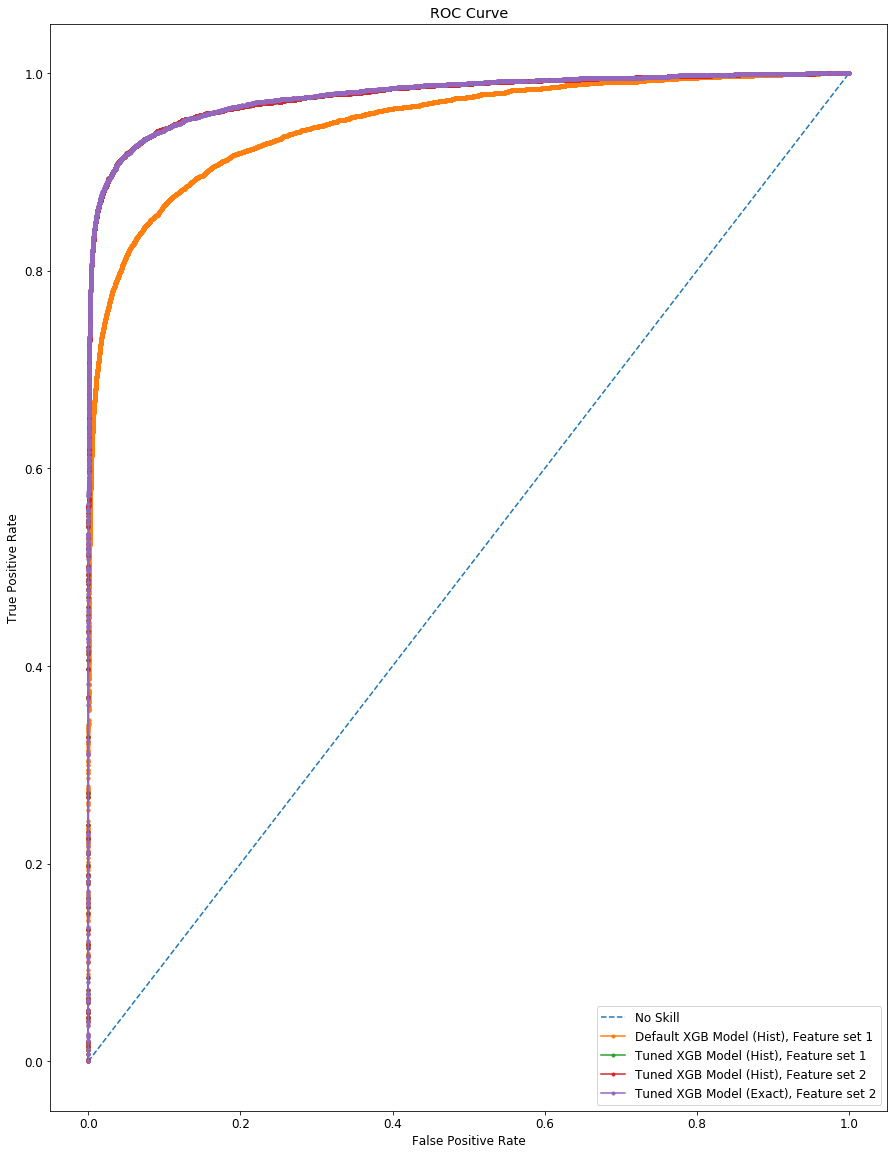

In [57]:
# plot ROC curve across models
plt.figure(figsize=(15, 20))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(m1_frp, m1_tpr, marker = '.', label='Default XGB Model (Hist), Feature set 1')
plt.plot(m2_frp, m2_tpr, marker = '.', label='Tuned XGB Model (Hist), Feature set 1')
plt.plot(m3_frp, m3_tpr, marker = '.', label='Tuned XGB Model (Hist), Feature set 2')
plt.plot(m4_frp, m4_tpr, marker = '.', label='Tuned XGB Model (Exact), Feature set 2')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Define HyperOpt function

In [ ]:
'''
Sample params
1. 
(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)





'''

In [ ]:
# Define hyperparameter space for tuning
param_space = {
'n_estimators' : 500,
'max_depth': 9,
'learning_rate': 0.05,
'subsample': 0.9,
'colsample_bytree': 0.9,
'missing': -999,
'min_child_weight': 1,   
'tree_method' : 'Exact',
    
'''
Tree methods in XGBoost: 
Exact -> Greedy algo, most intensive
Approx -> Approx Greedy, using quantile sketch & gradient histogram
Hist -> Fast histogram optimized version of Approx
GPU_Hist -> GPU version of Hist
GPU_Exact -> GPU version of Exact
Auto -> Auto choose from above
'''
'reg_alpha' : 0,
'reg_lambda' : 0,
'colsample_bylevel' : 1,
'colsample_bynode' : 1,
'colsample_bytree' : 0.9
}

In [ ]:
# also set up cross validation framework for hyperparameters tuning
cv_scores = cross_validate(model2, X, y, cv =3 , scoring=('roc_auc')\
                           , return_train_score=True)

In [ ]:
cv_scores

In [ ]:
# To-do: explore the differences between ‘roc_auc’, ‘roc_auc_ovr’,‘roc_auc_ovo’,
#roc_auc_ovr_weighted’,‘roc_auc_ovo_weighted’

In [ ]:
# Use Scikit-learn's GridSearch CV for next steps

## Predict fraud probabilities on test set and export to csv for Kaggle submission

In [ ]:
sample_submission['isFraud'] = model2.predict_proba(X_test)[:,1]
sample_submission.to_csv('simple_xgboost.csv')